# Scrape Jobindex

## Import packages

In [1]:
# import packages
import requests, json
import pandas as pd, numpy as np
import time, os

## Get web data

Procedure
collect the first page
save the totalresultcount for later usage


In [4]:
# the basic url
# https://www.jobindex.dk/jobsoegning.json?q=&jobage=archive&mindate=20180524&maxdate=20180824&page=2
url = 'https://www.jobindex.dk/jobsoegning.json'


# the request session
session = requests.session()
session.headers['email'] = 'pot@potweb.dk' 
session.headers['name'] = 'Peter Ottosen'
#session.headers['User-Agent'] = '' # sometimes you need to pose as another agent...
session.headers

# container for jobpostings
jobpostings = []
done = []

global last_t
last_t = time.time()

# function to create the next link
def create_link(offset_) :
    mindate = 20070101
    maxdate = 20070630
    addit = '?q=&jobage=archive&mindate=' + str(mindate) + '&maxdate=' + str(maxdate) + '&page=' + str(offset_)
    return url + addit

def ratelimit():
    time.sleep(.5) # sleep one second.

# Reliable requests
def get(url,iterations=10,check_function=lambda x: x.ok):
    """This module ensures that your script does not crash from connection errors.
        that you limit the rate of your calls
        that you have some reliability check
        iterations : Define number of iterations before giving up. 
        exceptions: Define which exceptions you accept, default is all. 
    """
    for iteration in range(iterations):
        try:
            # add ratelimit function call here
            ratelimit() # !!
            response = session.get(url)
            if response.ok:
                return response # if succesful it will end the iterations here
        except exceptions as e: #  find exceptions in the request library requests.exceptions
            print(e) # print or log the exception message.
    return None # your code will purposely crash if you don't create a check function later.

def log_function(url,response,error_check=lambda x: x.ok,separator=',') :
    global last_t
#    logfilepath = r"C:\Users\pot\Documents\GitHub\group19\Eksamensprojekt/log_jobindex3a.csv"
    logfilepath = r"C:\notebooks\group19\Eksamensprojekt/log_jobindex3a.csv"
    if os.path.isfile(logfilepath) :
        f_log = open(logfilepath,'a')
    else:
        f_log = open(logfilepath,'w') # define logfile, remember not to overwrite it.
        # write columns to be used, basic ones are, servertime, deltaT since last call, url, success of request, 
        header = ['serverTime','deltaT','url','success','length','path']
        f_log.write(','.join(header)+'\n')
    #### Update timing info ####
    t = time.time()
    delta_t = t-last_t # calculate time since last call
    last_t = t# update last call time
    #### meta data ### 
    success = error_check(response)
    if success: # if call is successfull we add it to the done container
        done.append(url)
    if response.ok:
        length = len(response.text)
    else:
        length = 0
    row = [t,delta_t,url,success,length,path]
    f_log.write(separator.join(map(str,row))+'\n')
    f_log.close()


# just to get the number of results
#offset = 1
count = 0
#r = get(create_link(offset))
#d=json.loads(r.text)

#ResultCount=d['TotalResultCount']
#jp_keys = d['JobPositionPostings'][0].keys()

for pages in range(1, 10301) : # pagineringen
    offset = pages
    link = create_link(offset)
    if link in done: #check if you have already downloaded the link
        continue
    count +=1
    r = get(link)
    d=json.loads(r.text)
#    jobpostings.append(d['JobPositionPostings'])

    #define path 
#    base_path = r"C:\Users\pot\Documents\GitHub/jobindex3.txt"
    base_path = r"C:\notebooks/jobindex3a.txt"
    path = base_path      # use the link count as a filename
    if r.ok:
        if os.path.isfile(path) :
            f = open(path, mode="a", encoding="utf8")
        else:
            f = open(path, mode="w", encoding="utf8") # define logfile, remember not to overwrite it.
            
        html = r.text
        try :
            f.write(html)
            f.write('\n')
        except UnicodeEncodeError :
            print("Der opstod en UnicodeEncodeError ved skrivning af side", str(pages))
            f.write(html)
            f.write('\n')
        else :
            pass
        f.close()
    # run your log function
    log_function(link, r)



## Import the packages

In [3]:
# import packages
import requests, json
import pandas as pd, numpy as np
import time, os
from bs4 import BeautifulSoup
import re
from datetime import datetime



## Parsing the data

The following steps parse the scraped html

### The first cell defines our parsing functions

In [4]:
def prepros(html) :
    d=json.loads(html)
    
    soup = BeautifulSoup(d['result_list_box_html'],'lxml')
    
    # this selects the main part of the html
    tabel = soup.find('div', attrs={'class':'results component--default'})
    
    # Jobindex contain both own postings and postings from other
    # the two are treated differently in the data
    # Jobindex' imported postings
    others = re.compile('r[\d]+')
    tabel1 = tabel.findAll('div', attrs={'data-beacon-tid':others})
#    print(tabel1)

    # Jobindex' own postings
    own = re.compile('h[\d]+')
    tabel2 = tabel.findAll('div', attrs={'data-beacon-tid':own})
    #print(tabel2)
    
    return tabel, tabel1, tabel2

def job_descr_own(tabel2) : # den er færdig (næsten, der kommer lidt snask med, men det er ok)
    desc_own = []
    lineshift = re.compile('\n')
    # tag ul skal med 
    for l in tabel2 :
        g1 = l.findAll('p') 
        g2 = l.findAll('li')
        qs = ''
#        print(g)
        for m in g1 :
            qs = qs + m.text + ". " 
        for m in g2 :
            if 'class=' not in m.text :
                qs = qs + m.text + ". " 
        desc_own.append(lineshift.sub("", qs))
    return desc_own

def job_descr_oth(tabel1) : # færdig og virker
    desc_oth = []
    p=re.compile('"')
    lineshift = re.compile('\n')
    besk = []
    for t_ in tabel1 :
        besk.append(lineshift.sub("", t_.text))
    for t in besk :
        s = t.split(sep='    ')
        if len(s) == 1 :
            desc_oth.append("")
        else :
            desc_oth.append(t.split(sep='    ')[1])
    return desc_oth
    
def job_title_oth (tabel) : # færdig og virker
    # udled jobs andre
    jobs_oth = []
    j = tabel.findAll('strong') 
    for l in j :
        jobs_oth.append(l.text)
    return jobs_oth

def job_title_own(tabel2) :
    a = []
    for l in tabel2 :
        try :
            a.append(l.findAll('b')[0].text)
        except :
            print("Der er ikke nogen stillingsbetegnelse", '\n')
            print(l)
            a.append('Ikke fundet')
    return a
    
def firm_place(tabel) : # ok
    firm=[]
    city=[]
    for tag in tabel :
        firm_city=tag.findAll('b')
        if len(firm_city) == 0 :
            firm.append("Ukendt")
            city.append("Uoplyst")
        elif len(firm_city) == 1 :
            firm.append(firm_city[0].text)
            city.append(" ")
        else :
            firm.append(firm_city[0].text)
            city.append(firm_city[1].text)
    return firm, city


def dates(tabel) : # ok
    indented_d=[]
    t_except = 0
    for tag in tabel :
        dato_site=tag.findAll('time')

        monthval={'januar': 1,'februar': 2, 'marts': 3, 'april': 4, 'maj': 5, 'juni': 6, \
                  'juli': 7,'august': 8,'september': 9,'oktober': 10,'november': 11,'december': 12}

        for i in dato_site:
            t = i.text.split()
            try :
                indented_d.append(datetime(int(t[2]), int(monthval.get(t[1])), int(t[0][:-1])))
            except :
                print("Rå tekst er '{}' og splittet tekst er '{}'".format(i.text, t))
    return indented_d

def firms_own_fct(tabel2):
    firms_own = []
    for tag in tabel2 :
        firms_egne=tag('img')
        regex = re.compile('alt="(.*?)" (?!border: 0px; margin: 0)')
        firms_own_=regex.findall(str(firms_egne))
        if len(firms_own_) == 0 :
            firms_own_ = 'Ukendt'
        firms_own.append(firms_own_[0])
    return firms_own


def cities_own(tabel2) :
    city_own = []
    for tag in tabel2 :
        cit = tag('p')
        regex = re.compile('</a>, (.+?)\s*?</p>')
        cities = regex.findall(str(cit))
        if len(cities) == 0 :
            cities = ['Uoplyst']
        city_own.append(cities[0])
    return city_own



### To test the parsing, we select a subsample

In [19]:
# select small subsample
import random, time

ca_samplesize = 20
base_path = r"C:/Notebooks/jobindex3.txt"
#base_path = r"C:\Users\pot\Documents\GitHub/jobindex.txt"
sample_path = r"C:/Notebooks/jobindex3_sample.txt"
#sample_path = r"C:\Users\pot\Documents\GitHub/jobindex3_sample.txt"
f = open(base_path,'r', encoding='UTF8')
s = open(sample_path, 'w', encoding='UTF8')
linienr = 0
t0 = time.time()
for line in f :
    ran = random.uniform(0, 1) 
    if ran < ca_samplesize/17000 :
        linienr += 1
        s.write(line)
f.close()
t1 = time.time()
print("Start:", t0, ". Slut:", t1, ". Linier hentet:", linienr)
print("Kørseltid:", round(t1-t0,2), "sekunder")




Start: 1535533965.9420662 . Slut: 1535533971.8223457 . Linier hentet: 15
Kørseltid: 5.88 sekunder


### The function that governs the parsing and concatanate the results

In [5]:

def process_data() :
    t0 = time.time()
    base_path = r"C:\notebooks\jobindex3a.txt" # file with scraped jobindex data
#    base_path = r"C:\Users\pot\Documents\GitHub\jobindex3b.txt" # file with scraped jobindex data
#    global lastdate 
#    last_date = datetime(2007,1,1)


    f = open(base_path, mode='r', encoding='utf8') # open the file for reading # jobindex2 skal læses med , encoding='utf8'
    count = 0
    # loop through the file one line at a time

    output_oth = pd.DataFrame(columns=['date', 'job_title', 'job_describ', 'city', 'company'])
    output_own = pd.DataFrame(columns=['date', 'job_title', 'job_describ', 'city', 'company'])
    t_except_own = 0
    t_except_oth = 0

   
    for html in f :
        count += 1

        if len(html) == 1 :
            continue
        # here the various processing functions will be called
        tabel, tabel1, tabel2= prepros(html)

        desc_own = job_descr_own(tabel2)

        desc_oth = job_descr_oth(tabel1)
        
        jobs_oth = job_title_oth(tabel)
        
        firm_oth, city_oth = firm_place(tabel1)
        
        post_dates_oth = dates(tabel1)

        post_dates_own = dates(tabel2)

        firms_own = firms_own_fct(tabel2)

        city_own = cities_own(tabel2)

        jobs_own = job_title_own(tabel2)


    # der skal laves en zip-funktion, så de kan blive sat rigtig sammen
        tmp = pd.DataFrame(list(zip(post_dates_oth, jobs_oth, desc_oth, city_oth, firm_oth)), 
                           columns=['date', 'job_title', 'job_describ', 'city', 'company'])
        output_oth = pd.concat([output_oth, tmp], axis=0, join='inner', ignore_index=True)

        tmp2 = pd.DataFrame(list(zip(post_dates_own, jobs_own, desc_own, city_own, firms_own)),
                           columns=['date', 'job_title', 'job_describ', 'city', 'company'])
        output_own = pd.concat([output_own, tmp2], axis=0, join='inner', ignore_index=True)
    f.close()
    t1 = time.time()
    
    print("Procestid er", int((t1-t0)/60), "minutter og", round((t1-t0)%60, 2), "sekunder")

    return output_oth, output_own

output_oth, output_own = process_data()

#Procestid er 17 minutter og 59.43 sekunder for both1
#Procestid er 6 minutter og 31.98 sekunder for both2

Procestid er 13 minutter og 25.33 sekunder


### Saves the outcome with pandas pickle

In [6]:
# gem data

print(output_oth.shape)
print(output_own.shape)

df_both = pd.concat([output_oth, output_own], axis=0, join='outer', ignore_index=True)
print(df_both.shape)

df_both.to_pickle('both5.pkl')

print(len(df_both[df_both['date'] > datetime(2008,12,31)]))


(181856, 5)
(24144, 5)
(206000, 5)
0


### Procedure to read the pandas pickle

In [3]:
# læs data 
ny1 = pd.read_pickle('both3.pkl')
ny2 = pd.read_pickle('both4.pkl')

df_both = pd.concat([ny1, ny2], axis=0, join='inner', ignore_index=True)

print("Shape", ny2.shape)
print("\n")
print(ny2.head(1), "\n", ny2.tail(2))



Shape (172780, 5)


        date                                          job_title  \
0 2010-12-31  Lagermedarbejdere søges til korte vikariater i...   

                                         job_describ       city  \
0  Vi søger dygtige, stabile og erfarne lagermeda...  Helsingør   

                       company  
0  Assistance Personaleservice   
              date                                          job_title  \
172778 2010-01-01    Kan du få tingene til at ske? Økonomielev søges   
172779 2010-01-01  Kommunikationschef der kan sætte konkurrence p...   

                                              job_describ        city  \
172778  DHL, Vallensbæk.  Jobmulighederne i DHL er uen...  Vallensbæk   
172779  Konkurrencestyrelsen, København.  Vi søger en ...   København   

                     company  
172778                   DHL  
172779  Konkurrencestyrelsen  


In [47]:
#for dates in pd.unique(df_both.date) :
#    print(dates)

cities = {}
for obs in df_both.city :
    cities[obs] += 1

companies = {}
for obs in df_both.company :
    companies[obs] += 1


KeyError: 'Region Midtjylland'

In [1]:
import numpy as np, pandas as pd
import re

In [2]:
# Stednavne
stednavne = pd.read_csv('stednavne.csv', sep=';', encoding='ANSI')

stednavne2 = stednavne[stednavne['Type'] == 'By']
#stednavne2['KommuneKode'] = int(stednavne2['KommuneKode'])
#print(stednavne2.head())

# kommuner, landsdele
kommuner = pd.read_excel('kommuner.xls')
#print(kommuner.head())

# Samlet stednavn, kommune, landsdel, region
stednavn3 = pd.merge(stednavne2, kommuner, how='inner', left_on=('KommuneKode'), right_on=('k_kode'))
stednavn4 = stednavn3[['Navn', 'kommune', 'k_kode', 'RegionNavn', 'RegionKode', 'landsdel', 'l_kode']]
#print(stednavn4.head())


dict_komm = pd.Series(list(stednavn3.kommune), index=list(stednavn3.Navn)).to_dict()
dict_landsdel = pd.Series(list(stednavn3.landsdel), index=list(stednavn3.Navn)).to_dict()
dict_region = pd.Series(list(stednavn3.RegionNavn), index=list(stednavn3.Navn)).to_dict()


In [4]:
sted='Søndbjerg'
dict_landsdel[sted]

'Vestjylland'

In [3]:
dict_special = {'Kgs. Lyngby': 'Københavns omegn', 
                'Grønland': 'Grønland', 
                'Brøndby': 'Københavns omegn',
                'Udlandet': 'Udlandet', 
                'Århus': 'Østjylland',
                'Copenhagen': 'Byen København', 
                'Bagsværd': 'Københavns omegn', 
                'Risskov': 'Østjylland', 
                'Allerød': 'Nordsjælland', 
                'Storkøbenhavn': 'Byen København', 
                'Fyn': 'Fyn', 
                'Brønshøj': 'Byen København', 
                'Dyssegård, Gladsaxe': 'Københavns omegn', 
                'Bornholm': 'Bornholm', 
                'Åbyhøj': 'Østjylland', 
                'Brabrand': 'Østjylland', 
                'Tilst': 'Østjylland', 
                'Stenløse': 'Nordsjælland',
                'Egå': 'Østjylland', 
                'Hasselager': 'Østjylland', 
                'Nykøbing Sj': 'Vest- og Sydsjælland', 
                'Nykøbing Sj.': 'Vest- og Sydsjælland', 
                'Nykøbing Sjælland': 'Vest- og Sydsjælland', 
                'Ølstykke': 'Nordsjælland', 
                'Hellerup, København': 'Københavns omegn', 
                'Karlslunde': 'Østsjælland', 
                'Smørum': 'Københavns omegn', 
                'Vallensbæk': 'Københavns omegn', 
                'Tranbjerg J': 'Østjylland', 
                'Vedbæk': 'Nordsjælland', 
                'Espergærde': 'Nordsjælland', 
                'Blåvand': 'Sydjylland', 
                'Samsø': 'Østjylland', 
                'Allerød, Hillerød': 'Nordsjælland', 
                'Broby': 'Fyn', 
                'Løsning': 'Østjylland', 
                'Sisimiut': 'Grønland', 
                'Silkeborg, Viborg': 'Østjylland', 
                'Allinge': 'Bornholm', 
                'Gladsaxe, Herlev': 'Københavns omegn', 
                'Fanø': 'Sydjylland', 
                'Rømø': 'Sydjylland', 
                'Holmegaard': 'Vest- og Sydsjælland',
                'Fårevejle': 'Vest- og Sydsjælland', 
                'Langå, Randers': 'Østjylland',
                'Qaqortoq': 'Grønland',
                'Rungsted Kyst': 'Nordsjælland', 
                'Klampenborg': 'Københavns omegn', 
                'Færøerne': 'Færøerne', 
                'Ilulissat': 'Grønland', 
                'Hvalsø': 'Vest- og Sydsjælland', 
                'Herfølge': 'Vest- og Sydsjælland', 
                'Henne': 'Sydjylland', 
                'Thyholm': 'Vestjylland', 
                'Herning, Holstebro': 'Vestjylland', 
                'Snekkersten': 'Nordsjælland',
                'Dyssegård': 'Københavns omegn', 
                'Maniitsoq': 'Grønland', 
                'Sydals': 'Sydjylland',
                'Kangerlussuaq': 'Grønland'}

dict_landsdel.update(dict_special)



In [5]:
ny1 = pd.read_pickle('both1.pkl')
ny2 = pd.read_pickle('both2.pkl')
ny3 = pd.read_pickle('both3.pkl')
ny4 = pd.read_pickle('both4.pkl')
ny5 = pd.read_pickle('both5.pkl')

df_both = pd.concat([ny1, ny2, ny3, ny4, ny5], axis=0, join='inner', ignore_index=True)

print(df_both.describe())
df_both_sample = df_both.sample(1000, random_state=1)

print(df_both_sample.head())

                       date job_title job_describ     city             company
count               1025180   1025180     1025180  1025180             1025180
unique                 1461    616779      749523     4039              140459
top     2007-12-06 00:00:00   Pædagog                       Københavns Kommune
freq                   2842      3908       53235    77916                7879
first   2007-01-01 00:00:00       NaN         NaN      NaN                 NaN
last    2010-12-31 00:00:00       NaN         NaN      NaN                 NaN
             date                                          job_title  \
530049 2007-10-18  Taxi Chauffør søges. Til kørsel ved Taxa Selan...   
819946 2007-06-29  FTZ Autodele & Værktøj A/S søger 1 ny lagermed...   
806655 2010-05-12                          Grid requirement engineer   
124205 2009-01-28  Assisterende centerleder til plejecenter Atriu...   
47777  2009-08-13                                    Lærer/overlærer   

              

In [5]:
def fetch_landsdel(key) :
    try :
        ld = dict_landsdel[key]
    except :        
        k = find_hidden(strip_comma(key))
        try :
            ld = dict_landsdel[k[0]]
        except:
            try :
                ld = dict_landsdel[k[1]]
            except :
                try :
                    ld = dict_landsdel[k[2]]
                except :
                    if key in [' ','Uoplyst'] :
                        ld = 'Uoplyst'
                    else :
                        ld = np.nan
    return ld
    
def find_hidden(key) :
    try :
        first = key.split()
    except :
        first = key
    return first

def strip_comma(key) :
    k1 = re.sub('/', " ", key)
    k2 = re.sub('ae', "æ", k1)
    k3 = re.sub('Å', "Aa", k2)
    k4 = re.sub('-', " ", k3)
    k5 = re.sub('oe', "ø", k4)
    return re.sub(',', "", k5)
    
df_both['landsdel'] = df_both['city'].apply(lambda x: fetch_landsdel(x))

len(df_both[df_both.landsdel.isnull()])
#42014


42014

In [6]:
from collections import Counter

ukendt_by = df_both[df_both['landsdel'].isnull()]['city']

print(len(pd.unique(ukendt_by)))
print(Counter(ukendt_by))




756
Counter({'Region Midtjylland': 9945, 'Region Sjælland': 7298, 'Region Nordjylland': 4369, 'Danmark': 4051, 'Sydjylland': 3409, 'Norge': 2797, 'Tyskland': 871, 'Luxembourg': 660, 'USA': 536, 'Østrig': 290, 'Qatar': 285, 'Schweiz': 273, 'Finland': 244, 'Australien': 224, 'Kina': 174, 'Irland': 167, 'Belgien': 157, 'Bjert': 155, 'Tisvildeleje': 130, 'Spanien': 129, 'Holland': 126, 'Vemmelev': 120, 'Canada': 117, 'Upernavik': 117, 'Hundige': 113, 'Agedrup': 112, 'Nuuk': 111, 'Italien': 105, 'Uummannaq': 105, 'Aasiaat': 101, 'Paamiut': 95, 'Ålsgårde': 91, 'Singapore': 91, 'Island': 90, 'Fur': 86, 'Tjekkiet': 80, 'Indien': 76, 'Storbritannien': 76, 'Tasiilaq': 71, 'Vietnam': 65, 'Japan': 64, 'Nanortalik': 61, 'Asperup': 58, 'Vejers Strand': 56, 'Avedøre': 56, 'Köpenhamn': 55, 'Kenya': 51, 'Tureby': 49, 'Narsaq': 46, 'Nordfyn': 45, 'Tanzania': 45, 'Uganda': 44, 'Angola': 43, 'Malaysia': 43, 'Bangladesh': 42, 'Stilling': 42, 'Nykøbing Mors': 41, 'Jordan': 38, 'Københavns vestegn': 38, 'Nyk

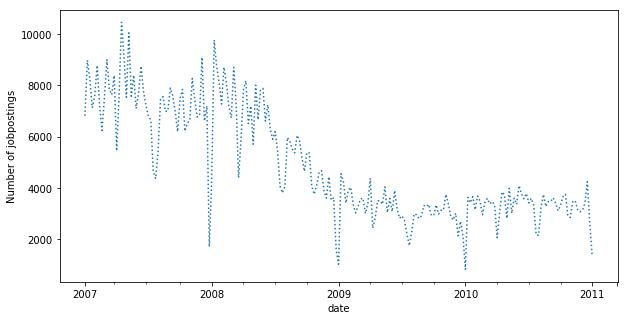

In [18]:
#per = df_both.['date'].dt.to_period("M")
a = df_both.copy()
a.set_index(['date'], inplace=True)
test = a.groupby(level=(0)).size()
#a.reset_index()

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 5))
ax.set_xlabel('Date')
ax.set_ylabel('Number of jobpostings')

#plt.hist2d(df_both['date'], df_both['landsdel'])

test.resample('W').sum().plot(style=':')
plt.savefig('weekly_postings.png')


In [1]:
import requests, json
import pandas as pd
pd.options.display.max_rows = 999

import time, os
import numpy as np

import random
import time

import requests
import json
from bs4 import BeautifulSoup
import PyDST
import re

# BNP data

In [2]:
conn = PyDST.connection(language = 'en')

In [3]:
res = conn.get_tables('06')
res.info

Getting all tables under topic code(s) {topics}


,ID,Description,Variables,Unit,Last updated,First observation,Latest observation,Active
0,PRIS111,Forbrugerprisindeks,"[varegruppe, enhed, tid]",-,2018-08-10T08:00:00,2001M01,2018M07,True
1,PRIS112,Forbrugerprisindeks,"[hovedtal, tid]",pct.,2018-01-10T08:00:00,1980,2017,True
2,PRIS8,"Forbrugerprisindeks, årsgennemsnit","[type, tid]",indeks,2018-01-10T08:00:00,1900,2017,True
3,PRIS9,"Forbrugerprisindeks, gennemsnitlig årlig infla...","[type, tid]",pct.,2018-01-10T08:00:00,1900,2017,True
4,PRIS113,"Forbrugerprisindeks, hovedtal","[type, tid]",indeks,2018-08-10T08:00:00,1980M01,2018M07,True
5,PRIS200,Husstandsopdelte forbrugerprisindeks,"[varegruppe, husstandsgrupper, tid]",indeks,2018-06-29T08:00:00,2006M01,2017M12,True
6,PRIS114,Nettoprisindeks,"[varegruppe, enhed, tid]",indeks,2018-08-10T08:00:00,2001M01,2018M07,True
7,PRIS115,Nettoprisindeks,"[hovedtal, tid]",indeks,2018-01-10T08:00:00,1980,2017,True
8,PRIS116,"Nettoprisindeks, hovedtal","[type, tid]",indeks,2018-08-10T08:00:00,1980M01,2018M07,True
9,PPP,Købekraftpariteter og internationale mængde- o...,"[varegruppe, land, enhed, tid]",-,2017-12-20T08:00:00,2000,2016,True


In [4]:
conn.get_metadata('NKN1').unit

Getting metadata for table NKN1


'-'

In [5]:
resp = conn.get_data(
                table_id = 'NKN1',
                variables = ['transakt', 'prisenhed', 'sæson', 'tid'])
#data = resp.df


            No values selected! Setting values to all ('*')
            
Getting table NKN1, variables are ['transakt', 'prisenhed', 'sæson', 'tid']
        values are {'transakt': ['*'], 'prisenhed': ['*'], 'sæson': ['*'], 'tid': ['*']}


In [6]:
data = resp.df
data

,TRANSAKT,PRISENHED,SÆSON,TID,INDHOLD
0,B.1*g Gross domestic product,"Current prices, (bill. DKK.)",Non-seasonally adjusted,1990Q1,210.2
1,B.1*g Gross domestic product,"Current prices, (bill. DKK.)",Non-seasonally adjusted,1990Q2,218.1
2,B.1*g Gross domestic product,"Current prices, (bill. DKK.)",Non-seasonally adjusted,1990Q3,209.5
3,B.1*g Gross domestic product,"Current prices, (bill. DKK.)",Non-seasonally adjusted,1990Q4,217.8
4,B.1*g Gross domestic product,"Current prices, (bill. DKK.)",Non-seasonally adjusted,1991Q1,220.2
5,B.1*g Gross domestic product,"Current prices, (bill. DKK.)",Non-seasonally adjusted,1991Q2,226.1
6,B.1*g Gross domestic product,"Current prices, (bill. DKK.)",Non-seasonally adjusted,1991Q3,219.6
7,B.1*g Gross domestic product,"Current prices, (bill. DKK.)",Non-seasonally adjusted,1991Q4,224.6
8,B.1*g Gross domestic product,"Current prices, (bill. DKK.)",Non-seasonally adjusted,1992Q1,228.1
9,B.1*g Gross domestic product,"Current prices, (bill. DKK.)",Non-seasonally adjusted,1992Q2,231.1


In [7]:
data['PRISENHED'].unique()

array(['Current prices, (bill. DKK.)',
       'Period-to-period real growth in per cent',
       'Pr. capita. Current prices, (1000 DKK.)',
       '2010-prices, chained values, (bill. DKK.)',
       'Contribution to GDP growth, (percentage point)',
       'Pr. capita, 2010-prices, chained values, (1000 DKK.)'],
      dtype=object)

In [8]:
BNP=data[(data['PRISENHED']=='2010-prices, chained values, (bill. DKK.)') & 
     (data['TRANSAKT']=='B.1*g Gross domestic product') & 
     (data['SÆSON']=='Non-seasonally adjusted') ]

In [9]:
BNP_1=data[(data['PRISENHED']=='2010-prices, chained values, (bill. DKK.)') & 
     (data['TRANSAKT']=='B.1*g Gross domestic product') & 
     (data['SÆSON']=='Seasonally adjusted') ]

In [10]:
BNP.columns=['TRANSAKT', 'PRICE UNIT', 'SEASON', 'TIME', 'GDP, BILLIONS OF DKK']

In [11]:
BNP_1.columns=['TRANSAKT', 'PRICE UNIT', 'SEASON', 'TIME', 'GDP, BILLIONS OF DKK']

In [12]:
BNP

,TRANSAKT,PRICE UNIT,SEASON,TIME,"GDP, BILLIONS OF DKK"
678,B.1*g Gross domestic product,"2010-prices, chained values, (bill. DKK.)",Non-seasonally adjusted,1990Q1,318.9
679,B.1*g Gross domestic product,"2010-prices, chained values, (bill. DKK.)",Non-seasonally adjusted,1990Q2,328.5
680,B.1*g Gross domestic product,"2010-prices, chained values, (bill. DKK.)",Non-seasonally adjusted,1990Q3,316.4
681,B.1*g Gross domestic product,"2010-prices, chained values, (bill. DKK.)",Non-seasonally adjusted,1990Q4,324.9
682,B.1*g Gross domestic product,"2010-prices, chained values, (bill. DKK.)",Non-seasonally adjusted,1991Q1,321.9
683,B.1*g Gross domestic product,"2010-prices, chained values, (bill. DKK.)",Non-seasonally adjusted,1991Q2,330.4
684,B.1*g Gross domestic product,"2010-prices, chained values, (bill. DKK.)",Non-seasonally adjusted,1991Q3,322.6
685,B.1*g Gross domestic product,"2010-prices, chained values, (bill. DKK.)",Non-seasonally adjusted,1991Q4,331.7
686,B.1*g Gross domestic product,"2010-prices, chained values, (bill. DKK.)",Non-seasonally adjusted,1992Q1,329.1
687,B.1*g Gross domestic product,"2010-prices, chained values, (bill. DKK.)",Non-seasonally adjusted,1992Q2,331.3


In [13]:
BNP_1

,TRANSAKT,PRICE UNIT,SEASON,TIME,"GDP, BILLIONS OF DKK"
791,B.1*g Gross domestic product,"2010-prices, chained values, (bill. DKK.)",Seasonally adjusted,1990Q1,..
792,B.1*g Gross domestic product,"2010-prices, chained values, (bill. DKK.)",Seasonally adjusted,1990Q2,..
793,B.1*g Gross domestic product,"2010-prices, chained values, (bill. DKK.)",Seasonally adjusted,1990Q3,..
794,B.1*g Gross domestic product,"2010-prices, chained values, (bill. DKK.)",Seasonally adjusted,1990Q4,..
795,B.1*g Gross domestic product,"2010-prices, chained values, (bill. DKK.)",Seasonally adjusted,1991Q1,326.6
796,B.1*g Gross domestic product,"2010-prices, chained values, (bill. DKK.)",Seasonally adjusted,1991Q2,325.4
797,B.1*g Gross domestic product,"2010-prices, chained values, (bill. DKK.)",Seasonally adjusted,1991Q3,329.5
798,B.1*g Gross domestic product,"2010-prices, chained values, (bill. DKK.)",Seasonally adjusted,1991Q4,325.2
799,B.1*g Gross domestic product,"2010-prices, chained values, (bill. DKK.)",Seasonally adjusted,1992Q1,331.1
800,B.1*g Gross domestic product,"2010-prices, chained values, (bill. DKK.)",Seasonally adjusted,1992Q2,329.1


In [14]:
BNP['YEAR']=BNP['TIME'].apply(lambda x: int(x.split('Q')[0]))
BNP_1['YEAR']=BNP_1['TIME'].apply(lambda x: int(x.split('Q')[0]))

/Users/mariannerasmussen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/mariannerasmussen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [15]:
BNP['QUARTER']=BNP['TIME'].apply(lambda x: int(x.split('Q')[1]))
BNP_1['QUARTER']=BNP_1['TIME'].apply(lambda x: int(x.split('Q')[1]))

/Users/mariannerasmussen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/mariannerasmussen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [16]:
BNP

,TRANSAKT,PRICE UNIT,SEASON,TIME,"GDP, BILLIONS OF DKK",YEAR,QUARTER
678,B.1*g Gross domestic product,"2010-prices, chained values, (bill. DKK.)",Non-seasonally adjusted,1990Q1,318.9,1990,1
679,B.1*g Gross domestic product,"2010-prices, chained values, (bill. DKK.)",Non-seasonally adjusted,1990Q2,328.5,1990,2
680,B.1*g Gross domestic product,"2010-prices, chained values, (bill. DKK.)",Non-seasonally adjusted,1990Q3,316.4,1990,3
681,B.1*g Gross domestic product,"2010-prices, chained values, (bill. DKK.)",Non-seasonally adjusted,1990Q4,324.9,1990,4
682,B.1*g Gross domestic product,"2010-prices, chained values, (bill. DKK.)",Non-seasonally adjusted,1991Q1,321.9,1991,1
683,B.1*g Gross domestic product,"2010-prices, chained values, (bill. DKK.)",Non-seasonally adjusted,1991Q2,330.4,1991,2
684,B.1*g Gross domestic product,"2010-prices, chained values, (bill. DKK.)",Non-seasonally adjusted,1991Q3,322.6,1991,3
685,B.1*g Gross domestic product,"2010-prices, chained values, (bill. DKK.)",Non-seasonally adjusted,1991Q4,331.7,1991,4
686,B.1*g Gross domestic product,"2010-prices, chained values, (bill. DKK.)",Non-seasonally adjusted,1992Q1,329.1,1992,1
687,B.1*g Gross domestic product,"2010-prices, chained values, (bill. DKK.)",Non-seasonally adjusted,1992Q2,331.3,1992,2


In [17]:
BNP[BNP['YEAR']>= 2007].to_csv('BNP_non_seasonally_adjust.csv')

In [18]:
BNP_1[BNP_1['YEAR']>= 2007].to_csv('BNP_seasonally_adjust.csv')

In [35]:
BNP[BNP['YEAR'].isin([2008,2009])]

,TRANSAKT,PRICE UNIT,SEASON,TIME,"GDP, BILLIONS OF DKK",YEAR,QUARTER
750,B.1*g Gross domestic product,"2010-prices, chained values, (bill. DKK.)",Non-seasonally adjusted,2008Q1,459.5,2008,1
751,B.1*g Gross domestic product,"2010-prices, chained values, (bill. DKK.)",Non-seasonally adjusted,2008Q2,475.6,2008,2
752,B.1*g Gross domestic product,"2010-prices, chained values, (bill. DKK.)",Non-seasonally adjusted,2008Q3,463.6,2008,3
753,B.1*g Gross domestic product,"2010-prices, chained values, (bill. DKK.)",Non-seasonally adjusted,2008Q4,470.6,2008,4
754,B.1*g Gross domestic product,"2010-prices, chained values, (bill. DKK.)",Non-seasonally adjusted,2009Q1,439.4,2009,1
755,B.1*g Gross domestic product,"2010-prices, chained values, (bill. DKK.)",Non-seasonally adjusted,2009Q2,442.4,2009,2
756,B.1*g Gross domestic product,"2010-prices, chained values, (bill. DKK.)",Non-seasonally adjusted,2009Q3,439.5,2009,3
757,B.1*g Gross domestic product,"2010-prices, chained values, (bill. DKK.)",Non-seasonally adjusted,2009Q4,456.3,2009,4


# Beskæftigelsesdata

In [36]:
resp_1 = conn.get_data(
                table_id = 'AKU103',
                variables = ['beskstatus', 'tid'])




            No values selected! Setting values to all ('*')
            
Getting table AKU103, variables are ['beskstatus', 'tid']
        values are {'beskstatus': ['*'], 'tid': ['*']}


In [37]:
data_1 = resp_1.df
data_1

,BESKSTATUS,TID,INDHOLD
0,Employed,1996Q1,2597
1,Employed,1996Q2,2612
2,Employed,1996Q3,2617
3,Employed,1996Q4,2623
4,Employed,1997Q1,2635
5,Employed,1997Q2,2658
6,Employed,1997Q3,2668
7,Employed,1997Q4,2674
8,Employed,1998Q1,2667
9,Employed,1998Q2,2660


In [38]:
conn.get_metadata('AKU103').variables

Getting metadata for table AKU103


['beskstatus', 'tid']

In [39]:
data_1.columns=['EMPLOY_STATUS', 'TIME', 'EMPLOYED, (1000 per.)']

In [40]:
EMPLOY=data_1[(data_1['EMPLOY_STATUS']=='Employed') ]

In [41]:
EMPLOY['YEAR']=EMPLOY['TIME'].apply(lambda x: int(x.split('Q')[0]))

/Users/mariannerasmussen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [42]:
EMPLOY['QUARTER']=EMPLOY['TIME'].apply(lambda x: int(x.split('Q')[1]))

/Users/mariannerasmussen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [25]:
EMPLOY

,EMPLOY_STATUS,TIME,"EMPLOYED, (1000 per.)",YEAR,QUARTER
0,Employed,1996Q1,2597,1996,1
1,Employed,1996Q2,2612,1996,2
2,Employed,1996Q3,2617,1996,3
3,Employed,1996Q4,2623,1996,4
4,Employed,1997Q1,2635,1997,1
5,Employed,1997Q2,2658,1997,2
6,Employed,1997Q3,2668,1997,3
7,Employed,1997Q4,2674,1997,4
8,Employed,1998Q1,2667,1998,1
9,Employed,1998Q2,2660,1998,2


In [26]:
EMPLOY[EMPLOY['YEAR']>= 2008].to_csv('test_employ.csv')

In [27]:
EMPLOY[EMPLOY['YEAR'].isin([2008,2009])]

,EMPLOY_STATUS,TIME,"EMPLOYED, (1000 per.)",YEAR,QUARTER
48,Employed,2008Q1,2771,2008,1
49,Employed,2008Q2,2812,2008,2
50,Employed,2008Q3,2820,2008,3
51,Employed,2008Q4,2818,2008,4
52,Employed,2009Q1,2774,2009,1
53,Employed,2009Q2,2733,2009,2
54,Employed,2009Q3,2727,2009,3
55,Employed,2009Q4,2673,2009,4


In [28]:
EMPLOY.drop(['EMPLOY_STATUS', 'TIME'], axis=1,inplace=True)

/Users/mariannerasmussen/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


# Konjunktur

In [116]:
conn.get_metadata('KONCYK1').variables

Getting metadata for table KONCYK1


['erhverv', 'mængde4', 'tid']

In [117]:
resp_4 = conn.get_data(
                table_id = 'KONCYK1',
                variables = ['erhverv', 'mængde4', 'tid'])


            No values selected! Setting values to all ('*')
            
Getting table KONCYK1, variables are ['erhverv', 'mængde4', 'tid']
        values are {'erhverv': ['*'], 'mængde4': ['*'], 'tid': ['*']}


In [118]:
data_4 = resp_4.df
data_4

,ERHVERV,MÆNGDE4,TID,INDHOLD
0,Manufacturing industries,Indicator level,1998M02,1.24
1,Manufacturing industries,Indicator level,1998M03,1.05
2,Manufacturing industries,Indicator level,1998M04,0.86
3,Manufacturing industries,Indicator level,1998M05,0.65
4,Manufacturing industries,Indicator level,1998M06,0.44
5,Manufacturing industries,Indicator level,1998M07,0.21
6,Manufacturing industries,Indicator level,1998M08,-0.03
7,Manufacturing industries,Indicator level,1998M09,-0.28
8,Manufacturing industries,Indicator level,1998M10,-0.54
9,Manufacturing industries,Indicator level,1998M11,-0.79


In [119]:
KONJUN=data_4[(data_4['MÆNGDE4']=='Month over month') ]
KONJUN

,ERHVERV,MÆNGDE4,TID,INDHOLD
246,Manufacturing industries,Month over month,1998M02,-0.19
247,Manufacturing industries,Month over month,1998M03,-0.19
248,Manufacturing industries,Month over month,1998M04,-0.20
249,Manufacturing industries,Month over month,1998M05,-0.20
250,Manufacturing industries,Month over month,1998M06,-0.21
251,Manufacturing industries,Month over month,1998M07,-0.23
252,Manufacturing industries,Month over month,1998M08,-0.24
253,Manufacturing industries,Month over month,1998M09,-0.26
254,Manufacturing industries,Month over month,1998M10,-0.26
255,Manufacturing industries,Month over month,1998M11,-0.24


In [120]:
KONJUN['YEAR']=KONJUN['TID'].apply(lambda x: int(x.split('M')[0]))
KONJUN['MONTH']=KONJUN['TID'].apply(lambda x: int(x.split('M')[1]))
KONJUN

/Users/mariannerasmussen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/mariannerasmussen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,ERHVERV,MÆNGDE4,TID,INDHOLD,YEAR,MONTH
246,Manufacturing industries,Month over month,1998M02,-0.19,1998,2
247,Manufacturing industries,Month over month,1998M03,-0.19,1998,3
248,Manufacturing industries,Month over month,1998M04,-0.20,1998,4
249,Manufacturing industries,Month over month,1998M05,-0.20,1998,5
250,Manufacturing industries,Month over month,1998M06,-0.21,1998,6
251,Manufacturing industries,Month over month,1998M07,-0.23,1998,7
252,Manufacturing industries,Month over month,1998M08,-0.24,1998,8
253,Manufacturing industries,Month over month,1998M09,-0.26,1998,9
254,Manufacturing industries,Month over month,1998M10,-0.26,1998,10
255,Manufacturing industries,Month over month,1998M11,-0.24,1998,11


In [121]:
KONJUN.columns=['PROFESSION', 'MEASURING', 'TIME', 'CONTENT', 'YEAR', 'MONTH']
KONJUN
KONJUN[KONJUN['YEAR'].isin([2008,2009])]

,PROFESSION,MEASURING,TIME,CONTENT,YEAR,MONTH
365,Manufacturing industries,Month over month,2008M01,-0.10,2008,1
366,Manufacturing industries,Month over month,2008M02,-0.12,2008,2
367,Manufacturing industries,Month over month,2008M03,-0.14,2008,3
368,Manufacturing industries,Month over month,2008M04,-0.17,2008,4
369,Manufacturing industries,Month over month,2008M05,-0.21,2008,5
370,Manufacturing industries,Month over month,2008M06,-0.25,2008,6
371,Manufacturing industries,Month over month,2008M07,-0.30,2008,7
372,Manufacturing industries,Month over month,2008M08,-0.35,2008,8
373,Manufacturing industries,Month over month,2008M09,-0.38,2008,9
374,Manufacturing industries,Month over month,2008M10,-0.39,2008,10


In [122]:
KONJUN.to_csv('test_KONJUN.csv')

# Import and append the data

In [405]:
import pandas as pd
import time
import sys
import datetime as datetime

#Indlæs data og formater dato formatet
df_1pt= pd.read_pickle('both1.pkl')
df_2pt= pd.read_pickle('both2.pkl')
df_3pt= pd.read_pickle('both3.pkl')
df_4pt= pd.read_pickle('both4.pkl')
df_5pt= pd.read_pickle('both5.pkl')

AL_df=df_1pt.append(df_2pt)
AL_df=AL_df.append(df_3pt)
AL_df=AL_df.append(df_4pt)
AL_df=AL_df.append(df_5pt)

AL_df.set_index(pd.DatetimeIndex(AL_df['date']), inplace=True)
del AL_df['date']
len(AL_df)

1025180

# Sammenlign BNP med joblisting

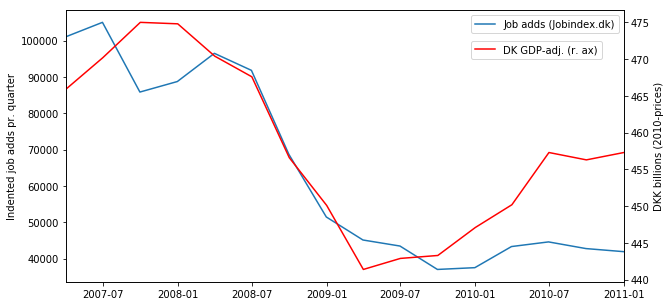

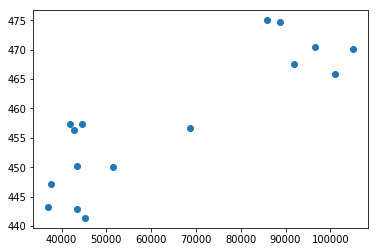

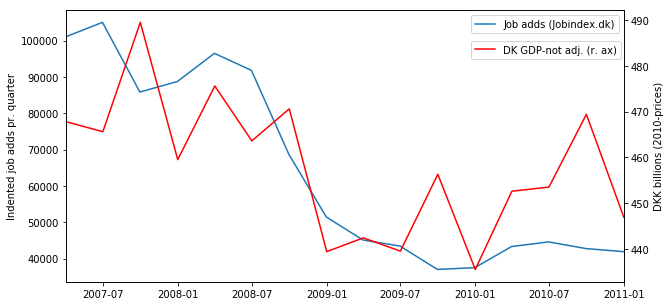

In [404]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure


#Gruppering af datoer pr. kvartal samt udarbejdelse af graf

g_1 = AL_df.groupby(pd.Grouper(freq="Q"))  # DataFrameGroupBy (grouped by quaters)
quater_frq=g_1.count()['city']

#import matplotlib.pyplot as plt
from matplotlib.pyplot import figure


#Gruppering af datoer pr. kvartal samt udarbejdelse af graf

g_1 = AL_df.groupby(pd.Grouper(freq="Q"))  # DataFrameGroupBy (grouped by quaters)
quater_frq=g_1.count()['city']


#BNP_seasonally_adjust.csv
AL_BNP=pd.read_csv('C:/Users/ander/Desktop/group19/Eksamensprojekt/BNP_seasonally_adjust.csv')
bnp=AL_BNP.iloc[:,4:6]
bnp=bnp[(bnp['TIME']<'2011Q2')]
bnp=bnp[(bnp['TIME']>'2007Q1')]
bnp.set_index(pd.DatetimeIndex(bnp['TIME']), inplace=True)
del bnp['TIME']


#Figure for kvartalsvis BNP + Jobindex (Fig.3)
fig, ax1 =plt.subplots(figsize=(10,5))

ax2 = ax1.twinx()
ax1.plot(quater_frq, label='Job adds (Jobindex.dk)')
ax1.legend(loc="upper right")
ax2.plot(bnp, label='DK GDP-adj. (r. ax)', color='r',)
ax2.legend(loc=[0.727,0.82])
ax1.set_ylabel("Indented job adds pr. quarter")
ax2.set_ylabel("DKK billions (2010-prices)")
plt.xlim(['2007-04','2011-01'])
plt.savefig('Fig3_1.png')
plt.show()

# BNP ukorrigerede faste priser
AL_BNP=pd.read_csv('C:/Users/ander/Desktop/group19/Eksamensprojekt/BNP_non_seasonally_adjust.csv')
bnp=AL_BNP.iloc[:,4:6]
bnp=bnp[(bnp['TIME']<'2011Q2')]
bnp=bnp[(bnp['TIME']>'2007Q1')]
bnp.set_index(pd.DatetimeIndex(bnp['TIME']), inplace=True)
del bnp['TIME']


#Figure for kvartalsvis BNP + Jobindex (Fig.3)
fig, ax1 =plt.subplots(figsize=(10,5))

ax2 = ax1.twinx()
ax1.plot(quater_frq, label='Job adds (Jobindex.dk)')
ax1.legend(loc="upper right")
ax2.plot(bnp, label='DK GDP-not adj. (r. ax)', color='r',)
ax2.legend(loc=[0.727,0.82])
ax1.set_ylabel("Indented job adds pr. quarter")
ax2.set_ylabel("DKK billions (2010-prices)")
plt.xlim(['2007-04','2011-01'])
plt.savefig('Fig3_2.png')
plt.show()



# Tester hvor mange hver vsh. har i perioden

In [18]:
#Annoncer i alt efter vsh.
from collections import Counter

AL_df07=AL_df[AL_df.index<'2008-01-01']
count07= pd.Series(AL_df07['company'].str.split(',').map(Counter).sum())

AL_df08=AL_df[(AL_df.index<'2009-01-01') & (AL_df.index>'2008-01-01')]
count08= pd.Series(AL_df08['company'].str.split(',').map(Counter).sum())


AL_df09=AL_df[(AL_df.index<'2010-01-01') & (AL_df.index>'2009-01-01')]
count09 = pd.Series(AL_df09['company'].str.split(',').map(Counter).sum())


AL_df10=AL_df[(AL_df.index<'2011-01-01') & (AL_df.index>'2010-01-01')]
count10 = pd.Series(AL_df10['company'].str.split(',').map(Counter).sum())



C:\Users\ander\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  
C:\Users\ander\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  import sys
C:\Users\ander\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  


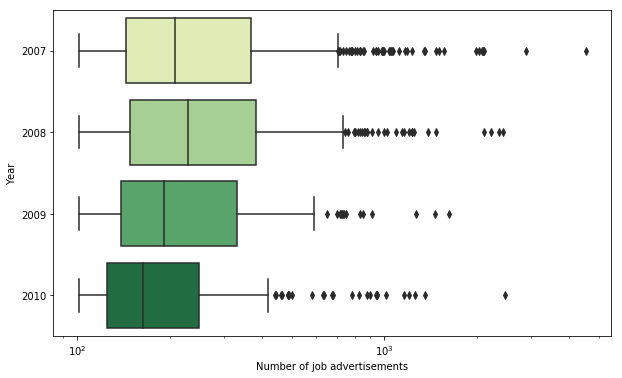

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt
headeryear=[2007,2008,2009,2010]
minant=100
AL_alldf=pd.DataFrame(count07[count07>minant])
AL_alldf=pd.concat([AL_alldf,count08[count08>minant]],axis=1)
AL_alldf=pd.concat([AL_alldf,count09[count09>minant]],axis=1)
AL_alldf=pd.concat([AL_alldf,count10[count10>minant]],axis=1)
AL_alldf.columns=headeryear


fig, ax = plt.subplots(figsize=(10,6))
ax = sns.boxplot(data=AL_alldf, orient="h", palette='YlGn')
ax.set(xlabel='Number of job advertisements', ylabel='Year')
ax.set_xscale('log')
plt.savefig('boxplot100log')

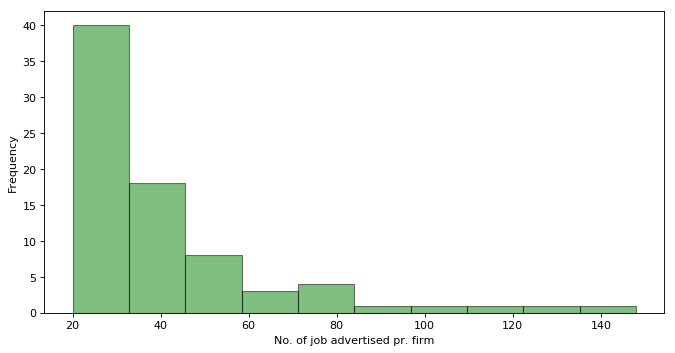

In [62]:
# #Histogram
# import matplotlib.pyplot as plt
# from matplotlib.pyplot import figure

# #Laver en dict til ovenstående afsnit
# n_jobs=count.sort_values(ascending=False)
# job_count=n_jobs[n_jobs>=20]

# #Creating a histogram
# figure(num=None, figsize=(10, 5), dpi=80, facecolor='w', edgecolor='b')
# plt.xlabel('No. of job advertised pr. firm')
# plt.ylabel('Frequency')
# plt.hist(job_count, bins=10, alpha=0.5,color='g', histtype='bar', ec='black')
# plt.savefig('Fig4.png')
# plt.show() 

# Bearbejd virksomheder i annonceringsdata

In [384]:
#Gruppering gruppering mht. Vsh og dato i jobannonce delen
import pandas as pd
pd.options.display.max_rows=1200


List=['Maersk','Carlsb', 'Colopla','Danske Ba','DSV','Jyske B','Nordea',\
      'Novo N','Novozy','Vestas','Tryg F','H. Lund', 'Alm. Br','SAS']           

month_frq=pd.DataFrame()


for i in List:
    C20list=AL_df[AL_df['company'].astype(str).str[0:len(i)]==i]
    gg = C20list.groupby(pd.Grouper(freq="M")) # DataFrameGroupBy (grouped by Month)
    month_frq=pd.concat([month_frq,gg.count()['company']], axis=1) 

c20job_headers=['Maersk','Carlsberg', 'Coloplast','Danske Bank','DSV','Jyske Bank','Nordea','Novo Nordisk','Novozymes','Vestas', 'Tryg','H. Lundbeck','Alm. Brand', 'SAS']

month_frq.columns=c20job_headers

# TAbel over annonceringer
jobs_sum=month_frq.describe().round(1).T
del jobs_sum['count']
jobs_sum

,mean,std,min,25%,50%,75%,max
Maersk,17.8,21.3,0.0,4.0,8.0,29.2,111.0
Carlsberg,16.8,8.8,5.0,10.0,14.0,20.2,41.0
Coloplast,13.7,12.5,0.0,5.0,9.5,18.0,55.0
Danske Bank,23.9,16.4,1.0,9.8,21.5,33.8,73.0
DSV,10.4,7.4,1.0,5.0,9.0,13.0,38.0
Jyske Bank,25.0,13.9,3.0,11.8,26.0,35.2,52.0
Nordea,32.9,18.8,5.0,19.0,30.0,44.2,102.0
Novo Nordisk,77.8,29.8,24.0,57.8,79.0,99.2,138.0
Novozymes,16.5,7.4,3.0,11.8,15.0,21.2,34.0
Vestas,152.4,76.7,1.0,89.2,159.0,200.2,345.0


# Indlæs aktiedata lokalt og tilpasning

In [383]:
tickers={'MAERSK_B':'CSE3201','CARL_B':'CSE1596',\
         'COLO_B':'CSE3203','DANSKE':'CSE1586','DSV':'CSE3415',\
         'JYSK':'CSE1587','NDA_DKK':'CSE4861','NOVO_B':'CSE1158',\
         'NZYM_B':'CSE11273','TRYG':'CSE31315','VWS':'CSE3258','LUN':'CSE3853',\
         'ALMB':'CSE3340','SAS_DKK':'CSE13584'}


path_csv="C:/Users/ander/Desktop/group19/Eksamensprojekt/omx_c20/"

df_c20=pd.DataFrame()

for i in tickers:
    nasd_csv=path_csv +str(i)+ "-2006-01-02-2018-08-28.csv"
    df= pd.read_csv(nasd_csv,sep=";",header=1, decimal=",")
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True) #Setting the date as index
    df_o=pd.DataFrame(df)
    df_r=df_o['Closing price'] # Getting only the closing price
    df_c20=pd.concat([df_c20,df_r], axis=1) 

headers=c20job_headers
df_c20.columns=headers
df_c20 #Closing prices with headersfor the chosen stock

#Aktiekurs EOM
    #df_c20=df_c20.groupby(pd.Grouper(freq='M')).nth(0) #getting the closing price of the last trading day in the month
df_c20l=df_c20.resample('M').last()
c20_stockp=df_c20l.iloc[12:60,:] #Reguler tidsafgrænsning


#Laver en gns. aktiekurs EOM
df_c20mean=df_c20.resample('M').mean()
c20_stockpmean=df_c20mean.iloc[12:60,:] #Reguler tidsafgrænsning


#Tabel 1 - stock prices 
c20p_sum=c20_stockp.describe().round(1).T
del c20p_sum['count']
c20p_sum

,mean,std,min,25%,50%,75%,max
Maersk,9512.5,2643.6,4920.0,7180.0,9385.0,11555.0,14500.0
Carlsberg,433.1,116.9,171.2,367.0,462.3,517.2,594.1
Coloplast,96.1,21.6,69.0,80.8,91.6,107.1,152.8
Danske Bank,137.6,55.8,34.5,109.0,126.7,177.4,243.8
DSV,94.7,22.3,41.1,82.1,97.6,112.1,136.0
Jyske Bank,251.4,97.8,96.2,178.6,230.2,330.0,417.3
Nordea,62.8,18.8,27.2,50.1,57.6,80.3,94.8
Novo Nordisk,69.5,18.9,48.5,57.5,62.8,68.8,125.8
Novozymes,107.3,21.9,76.7,88.2,101.3,128.4,155.4
Vestas,72.4,11.1,49.5,65.8,69.8,80.2,96.0


# Printer grafer for vsh. job annoncer + aktie kurser

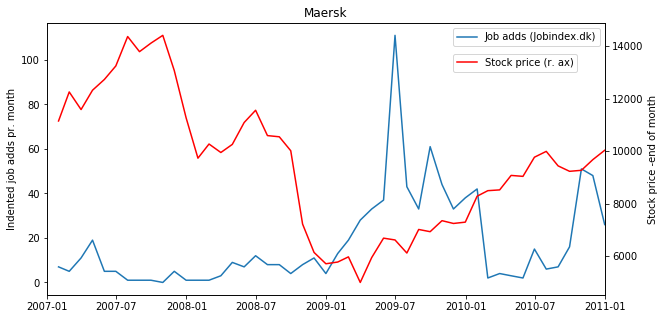

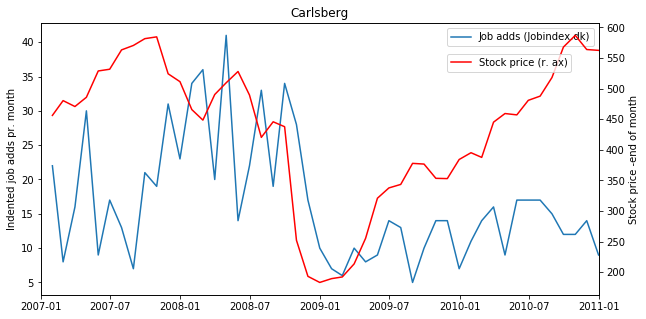

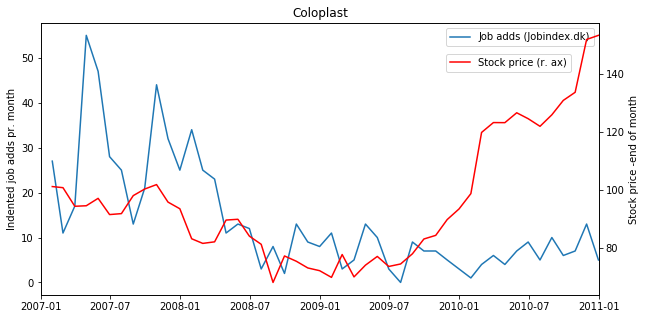

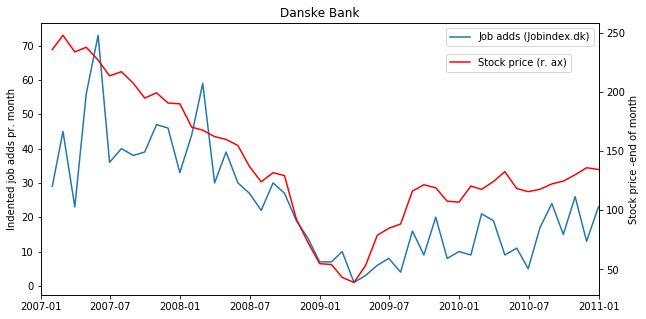

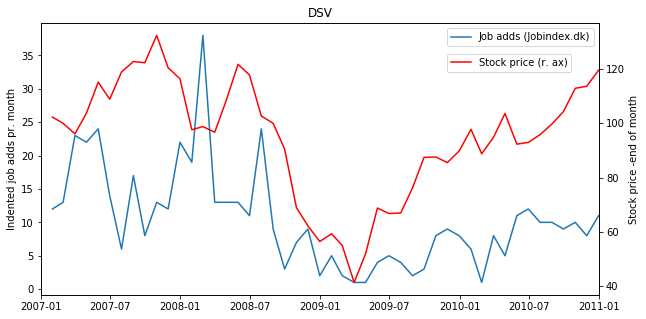

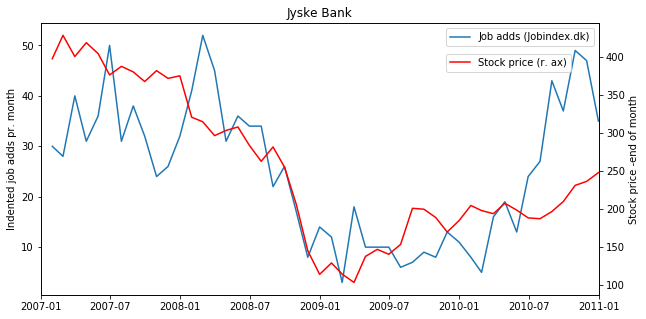

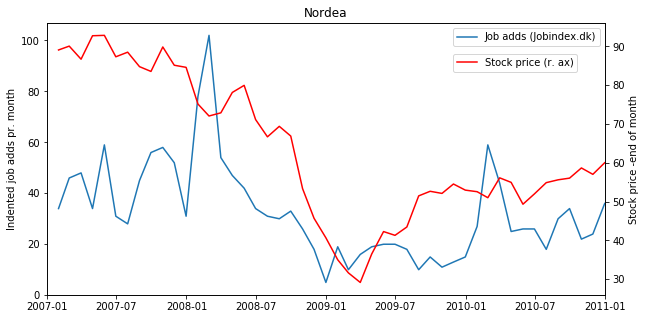

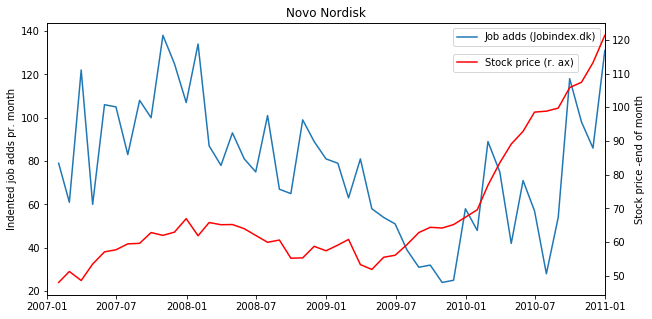

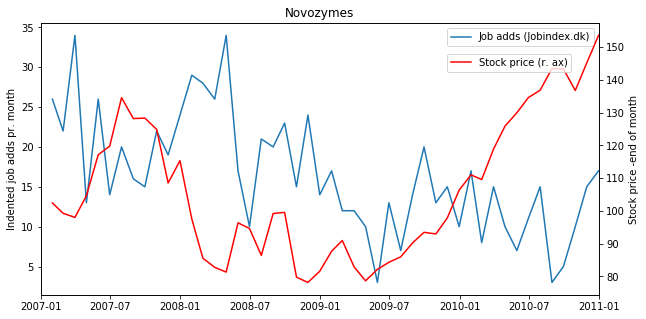

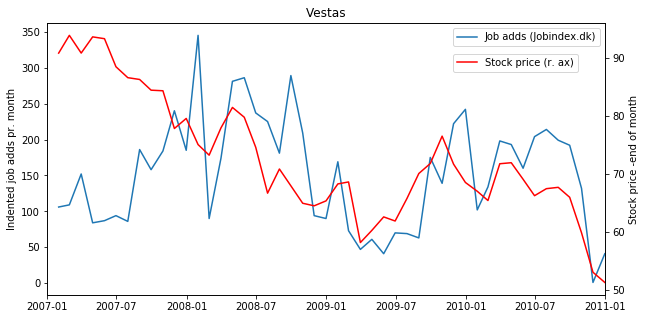

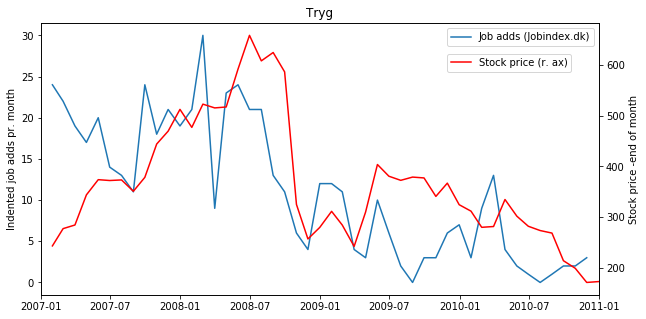

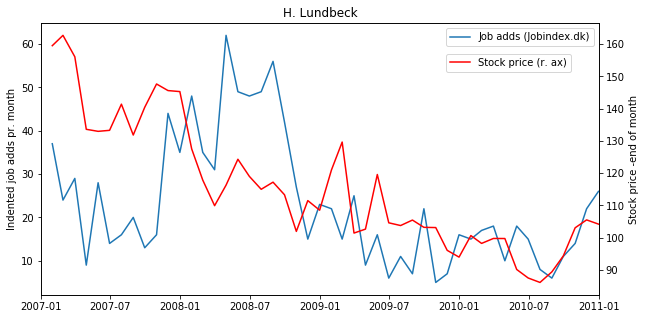

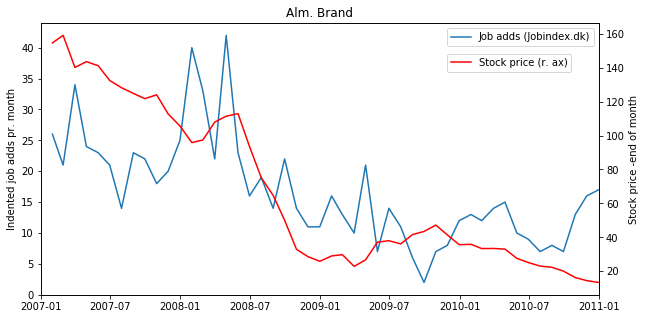

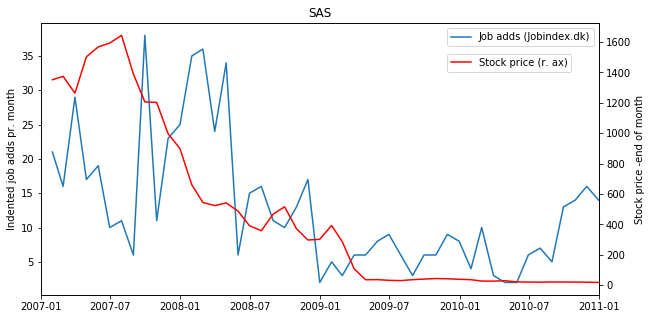

In [100]:

for i in month_frq.columns:
    fig, ax1 =plt.subplots(figsize=(10,5))
    ax2 = ax1.twinx()
    ax1.plot(month_frq[str(i)], label='Job adds (Jobindex.dk)')
    ax1.legend(loc="upper right")
    ax2.plot(c20_stockpmean[str(i)], label='Stock price (r. ax)', color='r',)
    ax2.legend(loc=[0.727,0.82])
    ax1.set_ylabel("Indented job adds pr. month")
    ax2.set_ylabel("Stock price -end of month")
    plt.xlim(['2007-01','2011-01'])
    plt.title(i)
    plt.savefig('Fig'+str(i)+'.png')
    plt.show()


    

# Scatterplot 

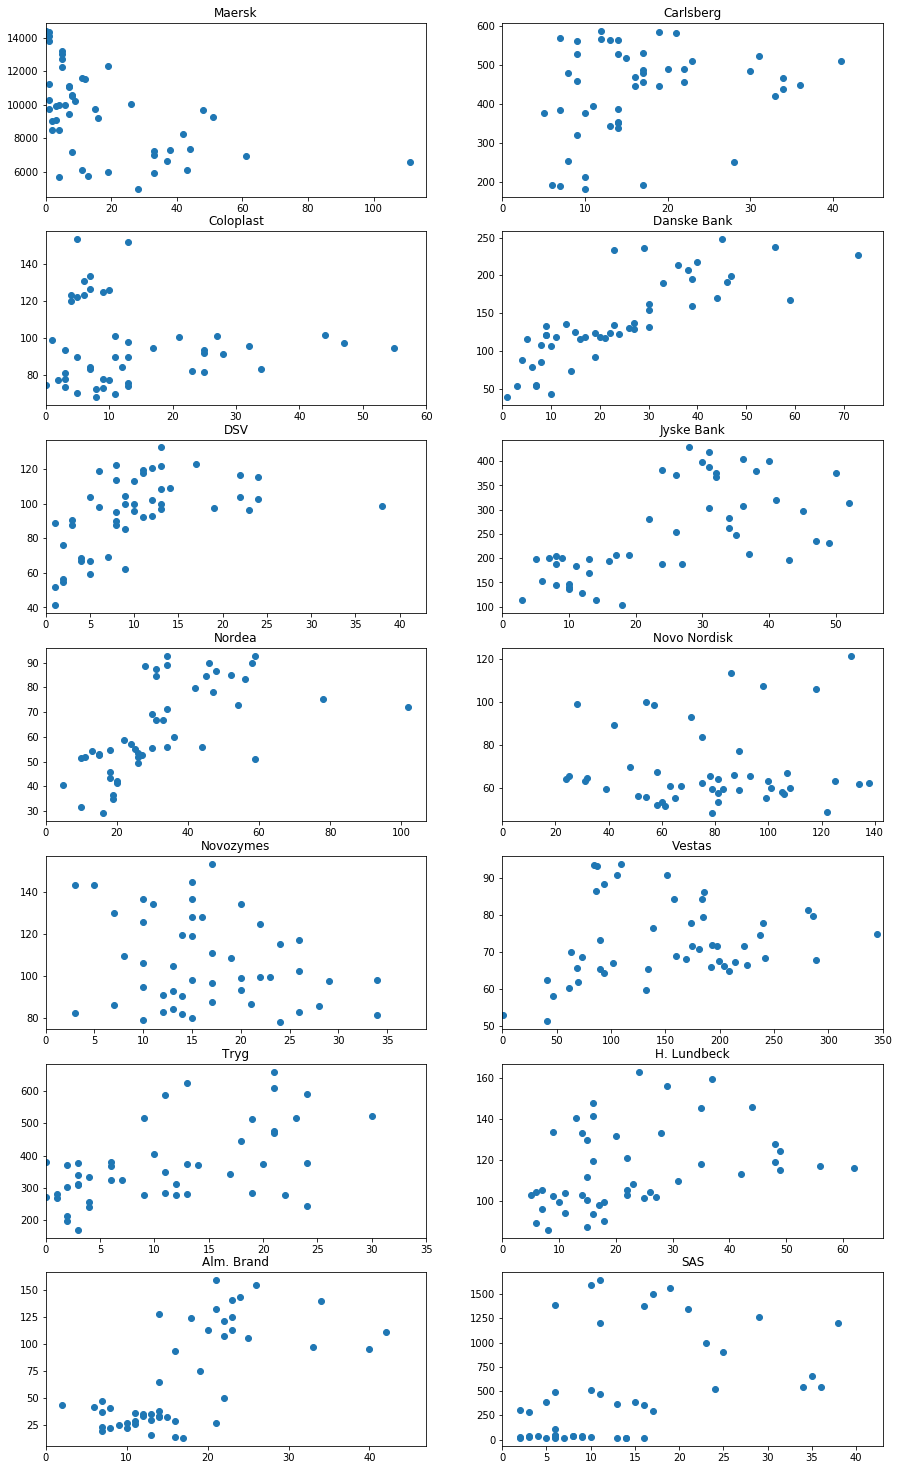

In [221]:
fig = plt.figure(figsize=(15,30))

for i in month_frq.columns:
    ax=fig.add_subplot(8,2,month_frq.columns.get_loc(str(i))+1)
    ax.scatter(month_frq[str(i)],c20_stockpmean[str(i)])
    ax.set_title(i)
    ax.set_xlim(0,max(month_frq[str(i)]+5))


plt.savefig('scatterstock.png')    
plt.show()

In [304]:
#Definer ny tabel til Modellering
jobs_ialt=month_frq.iloc[:,1:]
jobs_ialt.columns=['Carlsberg_jobs', 'Coloplast_jobs','Danske_Bank_jobs','DSV_jobs','Jyske_Bank_jobs','Nordea_jobs',\
                   'Novo_Nordisk_jobs','Novozymes_jobs','Vestas_jobs', 'Tryg_jobs','H_Lundbeck_jobs','Alm_Brand_jobs', 'SAS_jobs']

alt_ialt=c20_stockpmean.iloc[:,1:]
alt_ialt=pd.concat([alt_ialt,jobs_ialt],axis=1)
alt_ialt.to_pickle('job_kurser.pkl')

In [102]:
#Oneline multiindex convert #data = alt_ialt.reset_index().set_index(['entity','time'])

KeyError: 'entity'

# FE-estimation

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     15.04
Date:                Thu, 30 Aug 2018   Prob (F-statistic):           0.000115
Time:                        21:17:44   Log-Likelihood:                -547.01
No. Observations:                 671   AIC:                             1098.
Df Residuals:                     669   BIC:                             1107.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0010      0.021      0.049      0.9

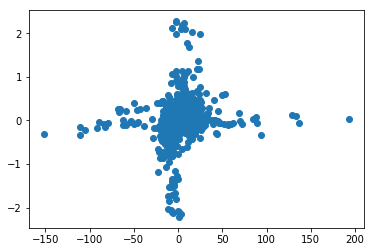

In [403]:
#Fixed Effect
import pandas as pd
import numpy as np

indgaar=['Maersk','Carlsberg', 'Coloplast','Danske Bank','DSV','Jyske Bank','Nordea','Novo Nordisk','Novozymes','Vestas', 'Tryg','H. Lundbeck','Alm. Brand', 'SAS']

#['Danske Bank','Jyske Bank','Nordea']

idx = []
# Setup variables
for vi in range(len(indgaar)):
    for i in range(48):
        idx.append(vi)

X1=[]
for k in indgaar:
    X_1 = list(month_frq.loc[:,str(k)])
    X1.append(X_1)
X1 = [j for i in X1 for j in i]


y=[]
for j in indgaar:
    y_ = list(c20_stockpmean.loc[:,str(j)])
    y.append(y_)
y = [j for i in y for j in i]
y=np.log(y)

    
df = pd.DataFrame({'idx': idx,'x1': X1,'y': y})
df1= df.copy


# Define transformer
def FE_transform(X):
    return X - np.mean(X)

df[['y', 'x1']] = df.groupby('idx')[['y', 'x1']].apply(FE_transform)


import statsmodels.formula.api as sm

modelFE = sm.ols('y ~ x1', data = df).fit()
print(modelFE.summary())
plt.scatter(df.x1,df.y)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.580
Model:                            OLS   Adj. R-squared:                  0.574
Method:                 Least Squares   F-statistic:                     97.48
Date:                Thu, 30 Aug 2018   Prob (F-statistic):           2.61e-27
Time:                        20:37:26   Log-Likelihood:                -4.4442
No. Observations:                 144   AIC:                             14.89
Df Residuals:                     141   BIC:                             23.80
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -5.626e-16      0.021  -2.68e-14      1.0

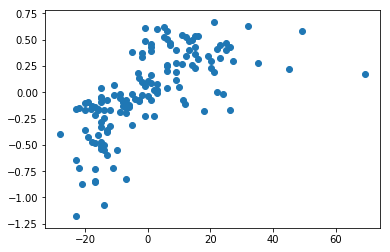

In [402]:
#Fixed Effect
import pandas as pd
import numpy as np

indgaar=['Danske Bank','Jyske Bank','Nordea']

idx = []
# Setup variables
for vi in range(len(indgaar)):
    for i in range(48):
        idx.append(vi)

X1=[]
for k in indgaar:
    X_1 = list(month_frq.loc[:,str(k)])
    X1.append(X_1)
X1 = [j for i in X1 for j in i]
X2=np.array(X1)**2

y=[]
for j in indgaar:
    y_ = list(c20_stockpmean.loc[:,str(j)])
    y.append(y_)
y = [j for i in y for j in i]
y=np.log(y)

    
df = pd.DataFrame({'idx': idx,'x1': X1,'x2':X2,'y': y})
df1= df.copy


# Define transformer
def FE_transform(X):
    return X - np.mean(X)

df[['y', 'x1','x2']] = df.groupby('idx')[['y', 'x1','x2']].apply(FE_transform)


import statsmodels.formula.api as sm

modelFE = sm.ols('y ~ x1+x2', data = df).fit()
print(modelFE.summary())
plt.scatter(df.x1,df.y)

# Pooled OLS

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     20.69
Date:                Thu, 30 Aug 2018   Prob (F-statistic):           6.40e-06
Time:                        20:28:40   Log-Likelihood:                -1161.2
No. Observations:                 671   AIC:                             2326.
Df Residuals:                     669   BIC:                             2335.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.2722      0.065     80.979      0.0

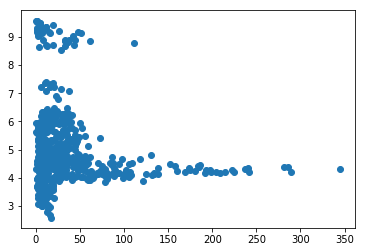

In [393]:
#OLS Pooled
import pandas as pd
import numpy as np

indgaar=['Maersk','Carlsberg', 'Coloplast','Danske Bank','DSV','Jyske Bank','Nordea','Novo Nordisk','Novozymes','Vestas', 'Tryg','H. Lundbeck','Alm. Brand', 'SAS']

idx = []
# Setup variables
for vi in range(len(indgaar)):
    for i in range(48):
        idx.append(vi)

X1=[]
for k in indgaar:
    X_1 = list(month_frq.loc[:,str(k)])
    X1.append(X_1)
X1 = [j for i in X1 for j in i]


y=[]
for j in indgaar:
    y_ = list(c20_stockpmean.loc[:,str(j)])
    y.append(y_)
y = [j for i in y for j in i]
y=np.log(y)

    
dfPOLS = pd.DataFrame({'idx': idx,'x1': X1,'y': y})
dfPOLS.groupby('idx')[['y', 'x1']]

import statsmodels.formula.api as sm

modelPOLS = sm.ols('y ~ x1', data = dfPOLS).fit()
print(modelPOLS.summary())
plt.scatter(dfPOLS.x1,dfPOLS.y)

# Pooled OLS lagged

In [391]:
#Pooled OLS lagged
import pandas as pd
import numpy as np
lag=-1

indgaar=['Maersk','Carlsberg', 'Coloplast','Danske Bank','DSV','Jyske Bank','Nordea','Novo Nordisk','Novozymes','Vestas', 'Tryg','H. Lundbeck','Alm. Brand', 'SAS']

idx = []
# Setup variables
for vi in range(len(indgaar)):
    for i in range(48+lag):
        idx.append(vi)

X1=[]
for k in indgaar:
    X_1 = list(month_frq.iloc[0:lag,month_frq.columns.get_loc(str(k))])
    X1.append(X_1)
X1 = [j for i in X1 for j in i]


c20_stockpmeam_1=c20_stockpmean.shift(lag)

y=[]
for j in indgaar:
    y_ = list(c20_stockpmeam_1.iloc[0:lag,c20_stockpmean.columns.get_loc(str(j))])
    y.append(y_)
y = [j for i in y for j in i]
y=np.log(y)

    
dfPOLS_1 = pd.DataFrame({'idx': idx,'x1': X1,'y': y})
dfPOLS_1.groupby('idx')[['y', 'x1']]
import statsmodels.formula.api as sm

modelPOLS_1 = sm.ols('y ~ x1', data = dfPOLS_1).fit()
print(modelPOLS_1.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     20.62
Date:                Thu, 30 Aug 2018   Prob (F-statistic):           6.68e-06
Time:                        20:07:08   Log-Likelihood:                -1137.9
No. Observations:                 658   AIC:                             2280.
Df Residuals:                     656   BIC:                             2289.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.2651      0.066     80.276      0.0

In [392]:
#Fixed Effect lagged
import pandas as pd
import numpy as np
lag=-1

indgaar=['Maersk','Carlsberg', 'Coloplast','Danske Bank','DSV','Jyske Bank','Nordea','Novo Nordisk','Novozymes','Vestas', 'Tryg','H. Lundbeck','Alm. Brand', 'SAS']

idx = []
# Setup variables
for vi in range(len(indgaar)):
    for i in range(48+lag):
        idx.append(vi)

X1=[]
for k in indgaar:
    X_1 = list(month_frq.iloc[0:lag,month_frq.columns.get_loc(str(k))])
    X1.append(X_1)
X1 = [j for i in X1 for j in i]


c20_stockpmeam_1=c20_stockpmean.shift(lag)

y=[]
for j in indgaar:
    y_ = list(c20_stockpmeam_1.iloc[0:lag,c20_stockpmean.columns.get_loc(str(j))])
    y.append(y_)
y = [j for i in y for j in i]
y=np.log(y)

    
dfFE_1 = pd.DataFrame({'idx': idx,'x1': X1,'y': y})
dfFE_1=dfFE_1.groupby('idx')[['y', 'x1']].apply(FE_transform)
import statsmodels.formula.api as sm

modelFE_1= sm.ols('y ~ x1', data = dfFE_1).fit()
print(modelFE_1.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     13.48
Date:                Thu, 30 Aug 2018   Prob (F-statistic):           0.000261
Time:                        20:07:44   Log-Likelihood:                -532.88
No. Observations:                 658   AIC:                             1070.
Df Residuals:                     656   BIC:                             1079.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -2.42e-16      0.021  -1.14e-14      1.0

## Scraping OMX C20 stock prices from Nasdaq using Selenium and Chromedriver

In [8]:
#Data importet pr. 28-08-2018
from selenium import webdriver
import os.path


browser =webdriver.Chrome("C:/Users/ander/Downloads/chromedriver_win32/chromedriver.exe") # define path to your chromedriver

tickers={'MAERSK_B':'CSE3201','CARL_B':'CSE1596',\
         'COLO_B':'CSE3203','DANSKE':'CSE1586','DSV':'CSE3415',\
         'JYSK':'CSE1587','NDA_DKK':'CSE4861','NOVO_B':'CSE1158',\
         'NZYM_B':'CSE11273','TRYG':'CSE31315','VWS':'CSE3258','LUN':'CSE3853',\
         'ALMB':'CSE3340','SAS':'CSE13584'}

for i in tickers:
    urlblok=tickers.get(i)
    nasdurl='http://www.nasdaqomxnordic.com/aktier/microsite?Instrument=' + str(urlblok)
    browser.get(nasdurl) # opens a webpage using the browser objects get method.
    selector = '.showHistory > span:nth-child(1)' # define selector to the email field
    element = browser.find_element_by_css_selector(selector) # find this element using the .find_element_by_css_selector method
    element.click()
    selector='#fromDate'
    element = browser.find_element_by_css_selector(selector)
    startdate='2006-01-02' #Setting start date
    element.send_keys(startdate) # send the data
    selector='#btnUpdate > span:nth-child(1)'
    element=browser.find_element_by_css_selector(selector)
    element.click()
    selector='#exportExcel' #Downloading the data to the computer
    element=browser.find_element_by_css_selector(selector)
    element.click()

## Figures to introduction

In [1]:
#Figur 1  - taken manually from https://www.jobindex.dk/jobsoegning/analyse-kilder

import matplotlib.pyplot as plt
import matplotlib

#Job adds sources per. 26-08-2018
jobsammensætning={'Other job databases':3783, 'Jobcenter':3957,\
                  "Firm's job pages":285,"Jobindex":5745}
dictval=[]

for key, value in jobsammensætning.items():
    temp = [value]
    dictval.append(temp)


fig1, ax1 = plt.subplots()
ax1.pie(dictval, labels=jobsammensætning.keys(), autopct='%1.1f%%',
        shadow=True, startangle=90)

# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.savefig('Fig1.png')

<Figure size 640x480 with 0 Axes>

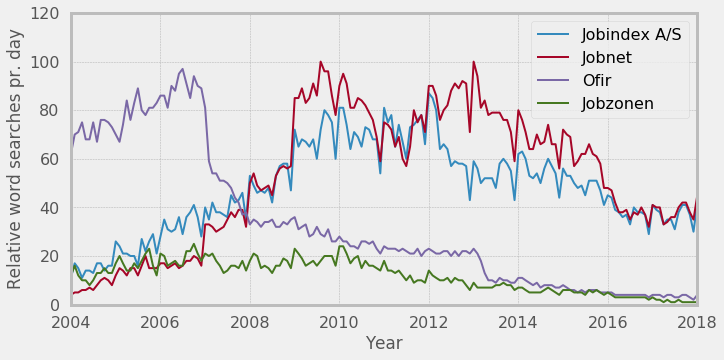

In [265]:
#Figur 2  - downloaded manually from https://trends.google.dk/trends/explore?date=all&geo=DK&q=%2Fm%2F0kbgkxk,Jobnet,Ofir,Jobzonen

import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
figure(figsize=(10,5))

#Job adds sources per. 26-08-2018
fig2_sti='C:/Users/ander/Desktop/group19/Eksamensprojekt/multiTimeline.csv'
fig2_csv=fig2_sti
df_fig2= pd.read_csv(fig2_csv, header=1)
df_fig2['Month'] = pd.to_datetime(df_fig2['Month'])
df_fig2.columns=['Year','Jobindex A/S', 'Jobnet', 'Ofir', 'Jobzonen']
#df_fig2.set_index('Year', inplace=True)
#df_fig2.plot.line()
plt.plot(df_fig2['Year'], df_fig2['Jobindex A/S'])
plt.plot(df_fig2['Year'], df_fig2['Jobnet'])
plt.plot(df_fig2['Year'], df_fig2['Ofir'])
plt.plot(df_fig2['Year'], df_fig2['Jobzonen'])
plt.xlabel('Year')
plt.ylabel('Relative word searches pr. day')
plt.ylim(0,120)
plt.xlim('01-01-2004','01-01-2018')
plt.legend()
plt.savefig('Fig2.png')



In [49]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
import time

from sklearn.metrics import mean_squared_error as mse
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold

%matplotlib inline

from sklearn.model_selection import train_test_split



In [50]:
# læs data 
df_est = pd.read_pickle('job_kurser.pkl')

print(df_est.head())


# def dan_xy(index) :
#     y = np.array((np.log(df_est.iloc[index])))
#     X = np.array((np.log(df_est.iloc[index+14]))).reshape(-1, 1)
#     return X, y

# X, y = dan_xy(7)
# X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=0.25, random_state=1)
# X_train, X_eval, y_train, y_eval = train_test_split(X_dev, y_dev, test_size=.25, random_state=2)

# X_train


             Carlsberg   Coloplast  Danske Bank         DSV  Jyske Bank  \
Date                                                                      
2007-01-31  456.189545  101.200000   235.768773  102.263636  397.664091   
2007-02-28  480.336250  100.815000   247.720700   99.975000  428.416050   
2007-03-31  470.682727   94.413636   233.739318   96.081818  400.536455   
2007-04-30  485.811778   94.594444   237.665111  103.672222  418.761556   
2007-05-31  528.809850   97.145000   226.807400  115.155000  404.439550   

               Nordea  Novo Nordisk   Novozymes     Vestas        Tryg  \
Date                                                                     
2007-01-31  89.079545     48.022727  102.440909  90.772727  242.977273   
2007-02-28  90.075000     51.272500   99.295000  93.835000  277.125000   
2007-03-31  86.704545     48.602273   98.013636  90.781818  284.295455   
2007-04-30  92.750000     53.472222  104.655556  93.572222  343.833333   
2007-05-31  92.850000     57.0

## Structure data

In [51]:
col_kurs = list(df_est.iloc[:,:13])
col_post = list(df_est.iloc[:,-13:])
print(col_post)
l = len(df_est)

container = pd.DataFrame(columns=['stock_price', 'job_postings', 'company'])
for i in range(len(col_kurs)) :
    yserie = np.log(df_est[col_kurs[i]]).shift(periods=-1)
    xserie = (df_est[col_post[i]])
    tmp = pd.DataFrame(pd.concat([yserie.iloc[:-1], xserie.iloc[:-1]], axis=1, ignore_index=True))
    tmp.columns=(['stock_price', 'job_postings'])
    tmp['company']=col_kurs[i]
    container = pd.concat([container, tmp], axis=0, ignore_index=True)
print(container.head())

['Carlsberg_jobs', 'Coloplast_jobs', 'Danske_Bank_jobs', 'DSV_jobs', 'Jyske_Bank_jobs', 'Nordea_jobs', 'Novo_Nordisk_jobs', 'Novozymes_jobs', 'Vestas_jobs', 'Tryg_jobs', 'H_Lundbeck_jobs', 'Alm_Brand_jobs', 'SAS_jobs']
   stock_price job_postings    company
0     6.174486           22  Carlsberg
1     6.154184            8  Carlsberg
2     6.185821           16  Carlsberg
3     6.270629           30  Carlsberg
4     6.275957            9  Carlsberg


In [52]:
container0 = container.fillna(0)#nan_to_num(container)
#banks=['Carlsberg', 'Coloplast', 'Danske Bank', 'DSV', 'Jyske Bank', 'Nordea', 'Novo Nordisk', 'Novozymes', 'Vestas', 'Tryg', 'H. Lundbeck', 'Alm. Brand', 'SAS']
banks=['Nordea', 'Danske Bank', 'Jyske Bank']
df_bank = container0[container0.company.isin(banks)]

#input_data = pd.get_dummies(container0, columns=['company'])
input_data = pd.get_dummies(df_bank, columns=['company'], drop_first=True)
#print(input_data)
features = list(input_data.iloc[:,1:])

input_data_l1 = input_data.shift()

# dan X og y
y = np.array(input_data['stock_price'])
X = np.array(input_data.iloc[:,1:])

# dan training og test
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

print(X_dev.shape, y_dev.shape)
print(X_test.shape, y_test.shape)
y = np.nan_to_num(y, copy=False)



(105, 3) (105,)
(36, 3) (36,)


## Regression

Predicted data: Mean=4.8484, STD=0.6086 and VAR=0.3704.
Measured data: Mean=4.8513, STD=0.5668 and VAR=0.3213.
The function:
y = 4.769 + 0.2813 * x0 + 0.3111 * x1 + -0.417 * x2

Intercept : 4.769
x0 = job_postings : 0.281
x1 = company_Jyske Bank : 0.311
x2 = company_Nordea : -0.417

R^2 Train: 0.813, test: 0.832
Mean squared error: 0.05385


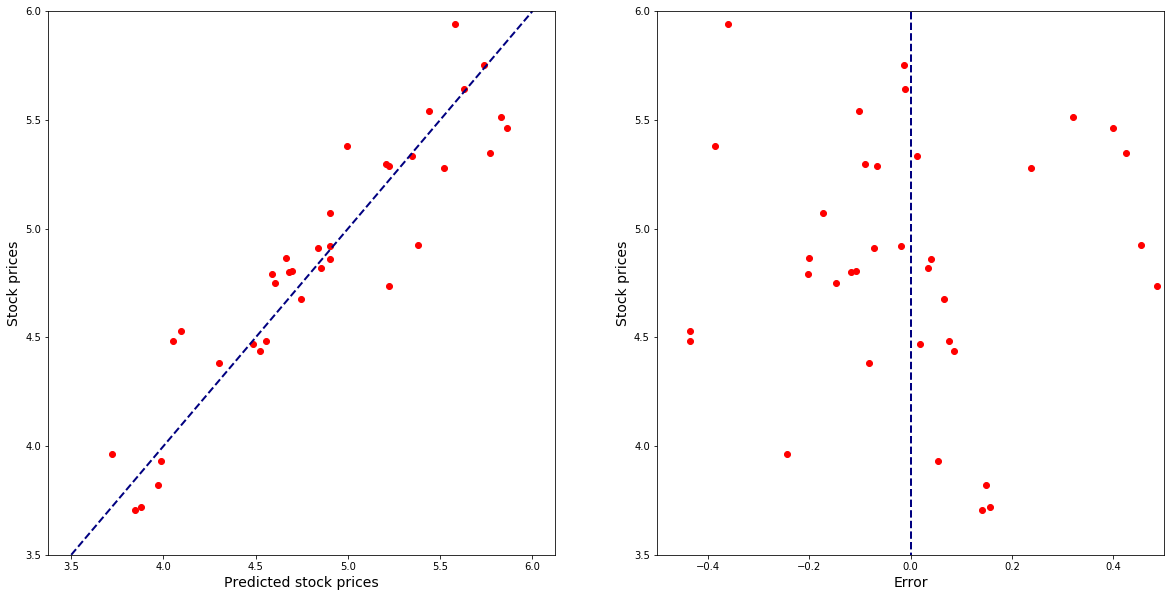

In [54]:

pipe_lr = make_pipeline(PolynomialFeatures(degree=1, include_bias=False),
                        StandardScaler(),
                        LinearRegression())

pipe_lr.fit(X_dev, y_dev)

feature_names = pipe_lr.named_steps.polynomialfeatures.get_feature_names()
coefficients = pipe_lr.named_steps.linearregression.coef_
intercept = pipe_lr.named_steps.linearregression.intercept_

#print("Beta =", pipe_lr.coef_[0])
#print('Alpha = ', pipe_lr.intercept_)

y_dev_hat = pipe_lr.predict(X_dev)
y_test_hat = pipe_lr.predict(X_test)

print("Predicted data: Mean={}, STD={} and VAR={}.".
      format(round(np.mean(y_test_hat), 4), round(np.std(y_test_hat), 4), round(np.var(y_test_hat), 4)))
print("Measured data: Mean={}, STD={} and VAR={}.".
      format(round(np.mean(y_test), 4), round(np.std(y_test), 4), round(np.var(y_test), 4)))

# print model info
print("The function:")
print('y =', round(intercept, 4), end='')
for i in range(len(feature_names)) :
    print(' +', round(coefficients[i], 4), "*", feature_names[i], end='')
print('\n')
print('Intercept :', round(intercept, 3))
for i in range(len(features)) :
    print(feature_names[i], "=", features[i], ":", round(coefficients[i], 3))
    
print('\nR^2 Train: %.3f, test: %.3f' % (r2_score(y_dev, y_dev_hat), r2_score(y_test, y_test_hat)))
print('Mean squared error: {}'.format(round(mse(y_test, y_test_hat),5)))


# make plot
font = {'size': 14,}

fig, ax = plt.subplots(1,2, figsize=(20,10))
ax[0].set_ylim(3.5,6)
ax[0].set_ylabel(ylabel='Stock prices', fontdict=font)
ax[0].set_xlabel(xlabel='Predicted stock prices', fontdict=font)

ax[1].set(ylim=(3.5,6), xlim=(-.5, .5))
ax[1].set_xlabel(xlabel='Error', fontdict=font)
ax[1].set_ylabel(ylabel='Stock prices', fontdict=font)

ax[0].scatter(pipe_lr.predict(X_test), y_test, color='red')
ax[1].scatter((pipe_lr.predict(X_test))-y_test, y_test, color='red')
ax[1].vlines(x=0, ymin=2.5, ymax=6.5, color='navy', lw=2, linestyle='--')

ax[0].plot([3.5, 6], [3.5, 6], color='navy', lw=2, linestyle='--')

plt.savefig('Fig_LinReg_lag(-1)_banks.png')

## Lasso

### Pure lasso

In [56]:
perform = []

kfolds = KFold(n_splits=3)

mseCV = []

alphas =  np.logspace(-5, 4, 12)

for alpha_ in alphas:
    
    pipe_lassoCV = make_pipeline(PolynomialFeatures(degree=1, include_bias=False),
                                 StandardScaler(),
                                 Lasso(alpha=alpha_, random_state=1))
    mseCV_ = []
    
    for train_idx, val_idx in kfolds.split(X_dev, y_dev):
        X_train, y_train = X_dev[train_idx], y_dev[train_idx]
        X_val, y_val = X_dev[val_idx], y_dev[val_idx] 

        pipe_lassoCV.fit(X_dev, y_dev)
        
        msetest = mse(pipe_lassoCV.predict(X_test), y_test)
        mseCV_.append(msetest)    
    mseCV.append(np.mean(mseCV_))

optimal = pd.Series(mseCV,index=alphas).nsmallest(1)
print("Optimal alpha")
print("alpha"," "*5, "Mean MSE")
print(optimal)
mseCV



Optimal alpha
alpha       Mean MSE
0.018738    0.049993
dtype: float64


[0.053844435775214944,
 0.05383030017816385,
 0.05373769406246524,
 0.05314557872127348,
 0.04999314944903605,
 0.06142770512953119,
 0.3280461910371138,
 0.3280461910371138,
 0.3280461910371138,
 0.3280461910371138,
 0.3280461910371138,
 0.3280461910371138]

Predicted data: Mean=4.847, STD=0.5803 and VAR=0.3367.
The function:
y = 4.769 + 0.2564 * x0 + 0.0 * x1 + 0.2978 * x2 + -0.3994 * x3

x0 = job_postings
x1 = company_Danske Bank
x2 = company_Jyske Bank
x3 = company_Nordea

R^2 Train: 0.811, test: 0.844
Mean squared error: 0.04999


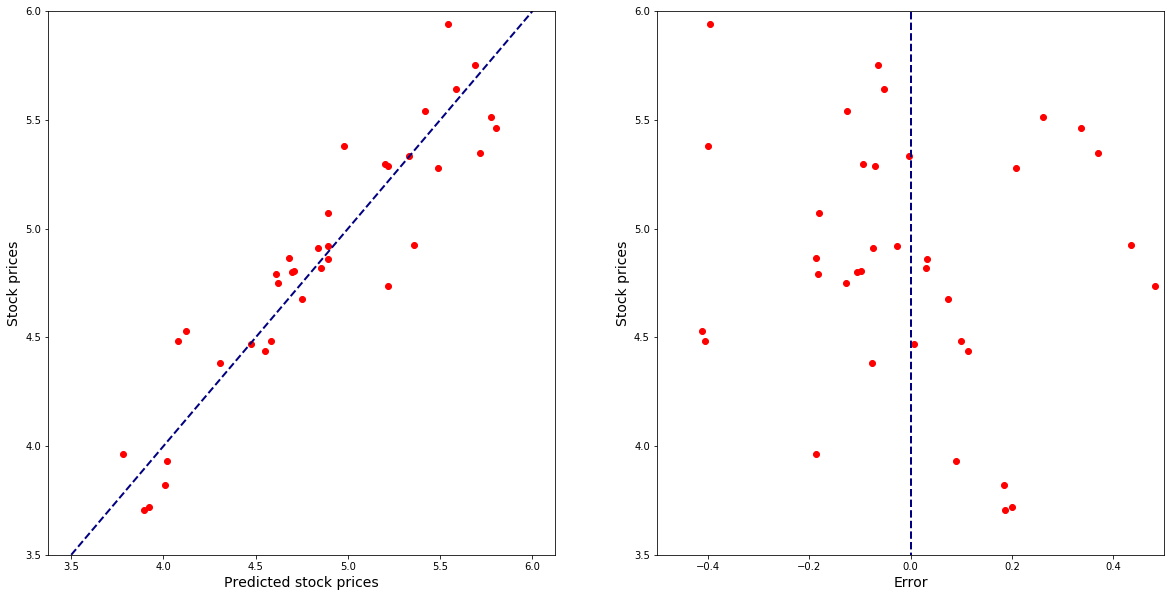

In [31]:
pipe_lasso = make_pipeline(PolynomialFeatures(degree=1, include_bias=False),
                                 StandardScaler(),
                                 Lasso(alpha=0.018738, random_state=1))
pipe_lasso.fit(X_dev, y_dev)

y_dev_hat = pipe_lasso.predict(X_dev)
y_test_hat = pipe_lasso.predict(X_test)

feature_names = pipe_lasso.named_steps.polynomialfeatures.get_feature_names()
coefficients = pipe_lasso.named_steps.lasso.coef_
intercept = pipe_lasso.named_steps.lasso.intercept_

# print model info
print("Predicted data: Mean={}, STD={} and VAR={}.".
      format(round(np.mean(y_test_hat), 4), round(np.std(y_test_hat), 4), round(np.var(y_test_hat), 4)))

print("The function:")
print('y =', round(intercept, 4), end='')
for i in range(len(feature_names)) :
    print(' +', round(coefficients[i], 4), "*", feature_names[i], end='')
print('\n')
for i in range(len(features)) :
    print(feature_names[i], "=", features[i])
    
print('\nR^2 Train: %.3f, test: %.3f' % (r2_score(y_dev, y_dev_hat), r2_score(y_test, y_test_hat)))

print('Mean squared error: {}'.format(round(mse(y_test, y_test_hat),5)))

# make plot
font = {'size': 14,}

fig, ax = plt.subplots(1,2, figsize=(20,10))
ax[0].set_ylim(3.5,6)
ax[0].set_ylabel(ylabel='Stock prices', fontdict=font)
ax[0].set_xlabel(xlabel='Predicted stock prices', fontdict=font)

ax[1].set(ylim=(3.5,6), xlim=(-.5, .5))
ax[1].set_xlabel(xlabel='Error', fontdict=font)
ax[1].set_ylabel(ylabel='Stock prices', fontdict=font)

ax[0].scatter(y_test_hat, y_test, color='red')
ax[1].scatter((y_test_hat - y_test), y_test, color='red')
ax[1].vlines(x=0, ymin=2.5, ymax=6.5, color='navy', lw=2, linestyle='--')

ax[0].plot([3.5, 6], [3.5, 6], color='navy', lw=2, linestyle='--')

plt.savefig('Fig_lasso_lag(-1)_banks.png')




### kFold and Ridge

In [58]:

kfolds = KFold(n_splits=3)

mseCV = []

lambdas =  np.logspace(-5, 4, 12)

for lambda_ in lambdas:
   
    pipe_RidgeCV = make_pipeline(PolynomialFeatures(degree=1, include_bias=False),
                                 StandardScaler(),
                                 Ridge(alpha=lambda_, random_state=1))    
    mseCV_ = []
    
    for train_idx, val_idx in kfolds.split(X_dev, y_dev):
        X_train, y_train = X_dev[train_idx], y_dev[train_idx]
        X_val, y_val = X_dev[val_idx], y_dev[val_idx] 

        pipe_RidgeCV.fit(X_dev, y_dev)
        
        msetest = mse(pipe_RidgeCV.predict(X_test), y_test)
        mseCV_.append(msetest)    
    mseCV.append(np.mean(mseCV_))

optimal = pd.Series(mseCV,index=lambdas).nsmallest(1)
print("Optimal lambda")
print("lambda"," "*5, "Mean MSE")
print(optimal)


Optimal lambda
lambda       Mean MSE
5.336699    0.050865
dtype: float64


Predicted data: Mean=4.8458, STD=0.5841 and VAR=0.3412.
The function:
y = 4.769 + 0.262 * x0 + 0.3036 * x1 + -0.3963 * x2

x0 = job_postings
x1 = company_Jyske Bank
x2 = company_Nordea

R^2 Train: 0.811, test: 0.842
Mean squared error: 0.05087


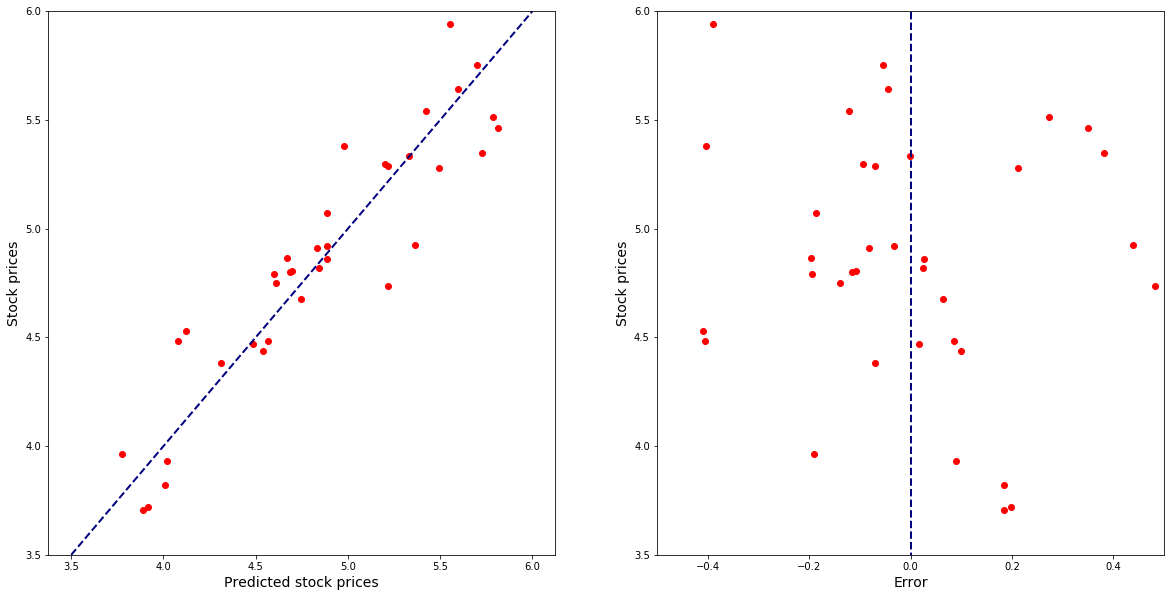

In [60]:
pipe_Ridge = make_pipeline(PolynomialFeatures(degree=1, include_bias=False),
                                 StandardScaler(),
                                 Ridge(alpha=5.336699, random_state=1))    
pipe_Ridge.fit(X_dev, y_dev)

y_dev_hat = pipe_Ridge.predict(X_dev)
y_test_hat = pipe_Ridge.predict(X_test)

feature_names = pipe_Ridge.named_steps.polynomialfeatures.get_feature_names()
coefficients = pipe_Ridge.named_steps.ridge.coef_
intercept = pipe_Ridge.named_steps.ridge.intercept_

# print model info
print("Predicted data: Mean={}, STD={} and VAR={}.".
      format(round(np.mean(y_test_hat), 4), round(np.std(y_test_hat), 4), round(np.var(y_test_hat), 4)))

print("The function:")
print('y =', round(intercept, 4), end='')
for i in range(len(feature_names)) :
    print(' +', round(coefficients[i], 4), "*", feature_names[i], end='')
print('\n')
for i in range(len(features)) :
    print(feature_names[i], "=", features[i])
    
print('\nR^2 Train: %.3f, test: %.3f' % (r2_score(y_dev, y_dev_hat), r2_score(y_test, y_test_hat)))

print('Mean squared error: {}'.format(round(mse(y_test, y_test_hat),5)))

# make plot
font = {'size': 14,}

fig, ax = plt.subplots(1,2, figsize=(20,10))
ax[0].set_ylim(3.5,6)
ax[0].set_ylabel(ylabel='Stock prices', fontdict=font)
ax[0].set_xlabel(xlabel='Predicted stock prices', fontdict=font)

ax[1].set(ylim=(3.5,6), xlim=(-.5, .5))
ax[1].set_xlabel(xlabel='Error', fontdict=font)
ax[1].set_ylabel(ylabel='Stock prices', fontdict=font)

ax[0].scatter(y_test_hat, y_test, color='red')
ax[1].scatter((y_test_hat - y_test), y_test, color='red')
ax[1].vlines(x=0, ymin=2.5, ymax=6.5, color='navy', lw=2, linestyle='--')

ax[0].plot([3.5, 6], [3.5, 6], color='navy', lw=2, linestyle='--')

plt.savefig('Fig_Ridge_lag(-1)_banks.png')

## Bag of words

### Stopwords

In [119]:
import nltk
stopwords = nltk.corpus.stopwords.words('danish')


### Get data and fit the CountVectorizer

In [135]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

ny1 = pd.read_pickle('both1.pkl')
ny2 = pd.read_pickle('both2.pkl')
ny4 = pd.read_pickle('both4.pkl')

df_both = pd.concat([ny1, ny2, ny4], axis=0, join='inner', ignore_index=True)

#print("Shape", df_both.shape)
#print("\n")
#print(df_both.head(1), "\n", df_both.tail(2))

desc = df_both.sample(60000, random_state=5)

#print(desc)


t0 = time.time()

count=TfidfVectorizer(ngram_range=(1, 3), max_df=.1, max_features=5000)
bag = count.fit_transform(desc['job_describ'].values)

t1 = time.time()

print("Procestid er", int((t1-t0)/60), "minutter og", round((t1-t0)%60, 2), "sekunder")

# 10000 linier: Procestid er 0 minutter og 0.78 sekunder

Procestid er 0 minutter og 17.5 sekunder


In [136]:
t0 = time.time()

X = count.transform(desc['job_describ'])

t1 = time.time()

print("Procestid er", int((t1-t0)/60), "minutter og", round((t1-t0)%60, 2), "sekunder")

# 10000 linier: Procestid er 0 minutter og 0.49 sekunder

Procestid er 0 minutter og 6.59 sekunder


In [137]:
print(X.shape)
# print(type(X))


(60000, 5000)


## LatentDirichletAllocation

In [138]:
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_topics=20, random_state=5, learning_method='batch')
t0 = time.time()

X_topics = lda.fit_transform(X)

t1 = time.time()

print("Procestid er {} minutter og {} sekunder".format(int((t1-t0)/60),round((t1-t0)%60, 2)))

# 10000 linier: Procestid er 0 minutter og 30.01 sekunder

Procestid er 2 minutter og 25.17 sekunder


In [91]:
print(lda.components_.shape)


(10, 2000)


In [139]:
n_top_words = 15
feature_names = count.get_feature_names()
for cat_idx, cat in (enumerate(lda.components_)) :
    print("Category %d:" % (cat_idx + 1))
    print(" ".join([feature_names[i] for i in cat.argsort()[:-n_top_words - 1:-1]]))
    

Category 1:
medarbejder muligt medarbejder til rengøring vi søger hurtigst hurtigst muligt en medarbejder til rengøring vi søger en frisk mangler och muligt en søges
Category 2:
kan det er du dig så skal kan du have god du er måske være for at så er du skal
Category 3:
timer pr 37 37 timer uge pædagog 30 snarest eller ugen 2009 om ugen 2010 pr uge timer pr
Category 4:
være være med vil du du være vil du være med til med til at være med til du være med del af en del en del af være en udvikle være en del
Category 5:
søges søges til dygtig til vores søger vi vi søger en dygtig snarest tiltrædelse vi søger en søger vi en vi en søges en job fra et job fra
Category 6:
efter løn overenskomst aftale efter aftale løn efter eller efter henhold henhold til nyt eller efter aftale løn og et nyt mail løn efter aftale
Category 7:
for at blive oprettet konsulenter kontakt med en vores konsulenter med en af du kontakt du kontakt med blive oprettet af vores konsulenter at blive virksomhedsbruger skal du

In [86]:
cat5 = X_topics[:, 4].argsort()[::-1]

for iter_idx, post_idx in enumerate(cat5[:3]) :
#    print(iter_idx, post_idx)
    print(desc['job_describ'].iloc[post_idx], "\n")

Sondrup Bilcenter A/S er en moderne handelsvirksomhed i stadig ekspansion. Vi er autoriseret Volvo og Renault forhandler, og har 5 afdelinger i Østjylland, med hovedkontor i Viby. Sondrup Bilcenter A/S ha 

Hos Euromaster Danmark A/S har vi søger vi en montør/udemontør til vores center i Skejby Om jobbet: - Montering af dæk på biler lastbiler og... 

Er du en ildsjæl der har lyst til at være med på holdet der udvikler fælles ledelsesinformation i en af Danmarks største virksomheder - så... 

